In [1]:
import pandas as pd

# CSV dosyasını oku
df = pd.read_csv("yangin_tweets.csv")

# İlk 5 satırı göster
df.head()

,Author,Date,Likes,Replies,Reposts,Text,Hashtag
0,@gazeteemek,2025-07-30T08:14:58.000Z,NaN,NaN,NaN,OGM: Çankırı’daki orman yangını kontrol altına...,yangin
1,@ozkan_dk,2025-07-30T08:14:58.000Z,NaN,NaN,NaN,Yav neden bu sahsıyetle kımse ılgılenmıyo sank...,yangin
2,@SaldaDernek,2025-07-30T08:14:55.000Z,NaN,NaN,NaN,"“2 dakikada görüyoz, 11 dakikada söndürüyoz” d...",yangin
3,@YKumluca79706,2025-07-30T08:14:38.000Z,NaN,NaN,NaN,Senden ayrı olmaz dedim.. #KademeHerYerde #Yen...,yangin
4,@filizyalcin06,2025-07-30T08:14:37.000Z,NaN,NaN,NaN,Aile ve Sosyal Hizmetler Bakanlığı yangın bölg...,yangin


In [2]:
# Gereksiz boşlukları düzelt
df['Text'] = df['Text'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()

# Tekrar edenleri sil (Author + Date + Text ile)
df.drop_duplicates(subset=['Author', 'Date', 'Text'], inplace=True)

# Boş içerikleri çıkar
df.dropna(subset=['Text'], inplace=True)

# Index'i sıfırla
df.reset_index(drop=True, inplace=True)

df.shape

(1842, 7)

In [3]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Saat dilimi bilgisini sil (opsiyonel)
df['Date'] = df['Date'].dt.tz_convert(None)

# Yeni tarih tipine bakalım
df.dtypes

Author             object
Date       datetime64[ns]
Likes             float64
Replies           float64
Reposts            object
Text               object
Hashtag            object
dtype: object

In [4]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Türkçe stopword listesi
stop_words = set(stopwords.words('turkish'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)             # URL kaldır
    text = re.sub(r"@\w+", "", text)                # Mention kaldır
    text = re.sub(r"#\w+", "", text)                # Hashtag kaldır
    text = re.sub(r"[^a-zçğıöşü\s]", "", text)       # Noktalama kaldır
    text = re.sub(r"\s+", " ", text).strip()        # Fazla boşluk temizle
    words = [word for word in text.split() if word not in stop_words]
    return " ".join(words)

df['CleanText'] = df['Text'].apply(clean_text)
df[['Text', 'CleanText']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ozanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Text,CleanText
0,OGM: Çankırı’daki orman yangını kontrol altına...,ogm çankırıdaki orman yangını kontrol altına a...
1,Yav neden bu sahsıyetle kımse ılgılenmıyo sank...,yav sahsıyetle kımse ılgılenmıyo sankı devlet ...
2,"“2 dakikada görüyoz, 11 dakikada söndürüyoz” d...",dakikada görüyoz dakikada söndürüyoz demişler ...
3,Senden ayrı olmaz dedim.. #KademeHerYerde #Yen...,senden ayrı olmaz dedim stifa
4,Aile ve Sosyal Hizmetler Bakanlığı yangın bölg...,aile sosyal hizmetler bakanlığı yangın bölgesi...


In [5]:
# Gerekli kütüphaneleri yükle
!pip install transformers torch sklearn

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# GPU kontrolü
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

# Türkçe BERT modelini yükle (dbmdz/bert-base-turkish-cased en iyisi)
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("BERT modeli yüklendi!")
print(f"Veri boyutu: {df.shape}")
print("İlk 3 temizlenmiş tweet:")
for i in range(3):
    print(f"{i+1}. {df['CleanText'].iloc[i][:100]}...")

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

Kullanılan cihaz: cpu


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ozanm\.cache\huggingface\hub\models--dbmdz--bert-base-turkish-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

BERT modeli yüklendi!
Veri boyutu: (1842, 8)
İlk 3 temizlenmiş tweet:
1. ogm çankırıdaki orman yangını kontrol altına alındı...
2. yav sahsıyetle kımse ılgılenmıyo sankı devlet gorevlısı ankarada sel olur ıstanbulda deprem bursada ...
3. dakikada görüyoz dakikada söndürüyoz demişler yaz saatlerce alev izliyoz günlerce duman soluyoz yana...


In [6]:
# Yangın ile ilgili anahtar kelimeleri tanımla
yangin_keywords = [
    'yangın', 'yangin', 'alev', 'ateş', 'duman', 'söndür', 'itfa', 'helikopter',
    'orman', 'ağaç', 'odun', 'kül', 'is', 'sıcak', 'tutuştu', 'yandı', 'yakıldı',
    'söndürme', 'müdahale', 'evakue', 'tahliye', 'zarar', 'hasar', 'yok oldu',
    'kurtarma', 'afad', 'jandarma', 'polis', 'ambulans', 'hastane'
]

# Tweet'leri sınıflandır (yangın ilgili: 1, değil: 0)
def classify_fire_tweet(text):
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    for keyword in yangin_keywords:
        if keyword in text_lower:
            return 1
    return 0

# Sınıflandırma yap
df['is_fire_related'] = df['CleanText'].apply(classify_fire_tweet)

# Sonuçları analiz et
fire_count = df['is_fire_related'].sum()
total_count = len(df)
fire_percentage = (fire_count / total_count) * 100

print(f"Toplam tweet sayısı: {total_count}")
print(f"Yangın ile ilgili tweet sayısı: {fire_count}")
print(f"Yangın ile ilgisiz tweet sayısı: {total_count - fire_count}")
print(f"Yangın tweet'lerinin oranı: %{fire_percentage:.1f}")

# Örnekleri incele
print("\nYangın ile ilgili tweet örnekleri:")
fire_tweets = df[df['is_fire_related'] == 1]['CleanText'].head(5)
for i, tweet in enumerate(fire_tweets, 1):
    print(f"{i}. {tweet[:100]}...")

print("\nYangın ile ilgisiz tweet örnekleri:")
non_fire_tweets = df[df['is_fire_related'] == 0]['CleanText'].head(5)
for i, tweet in enumerate(non_fire_tweets, 1):
    print(f"{i}. {tweet[:100]}...")

Toplam tweet sayısı: 1842
Yangın ile ilgili tweet sayısı: 1630
Yangın ile ilgisiz tweet sayısı: 212
Yangın tweet'lerinin oranı: %88.5

Yangın ile ilgili tweet örnekleri:
1. ogm çankırıdaki orman yangını kontrol altına alındı...
2. yav sahsıyetle kımse ılgılenmıyo sankı devlet gorevlısı ankarada sel olur ıstanbulda deprem bursada ...
3. dakikada görüyoz dakikada söndürüyoz demişler yaz saatlerce alev izliyoz günlerce duman soluyoz yana...
4. aile sosyal hizmetler bakanlığı yangın bölgesine sadece mio sadaka yardım gönderileceğini açıklarken...
5. peki kuruş maaşla geçinemeyenlere orman yangını deprem felaketlerde yetersizlikten ölene hasar gören...

Yangın ile ilgisiz tweet örnekleri:
1. senden ayrı olmaz dedim stifa...
2. hayat yanıyor...
3. bunlar öyle kimselerdir ahiretlerini dünya hayatı karşılığında satmışlardır onlardan azap hafifletil...
4. ortalık yanıyor normal...
5. olum fenerlilerin götü yanıyor sen anlatıyosun arama kısmına adamlar osimhen yaz keyfine bak m luk t...


In [7]:
# BERT için veri hazırlama
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Veriyi böl (train/test)
texts = df['CleanText'].fillna('').astype(str).tolist()
labels = df['is_fire_related'].tolist()

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nVeri bölünmesi:")
print(f"Eğitim seti: {len(X_train)} tweet")
print(f"Test seti: {len(X_test)} tweet")
print(f"Eğitim seti yangın oranı: %{(sum(y_train)/len(y_train)*100):.1f}")
print(f"Test seti yangın oranı: %{(sum(y_test)/len(y_test)*100):.1f}")

# BERT tokenization
max_length = 128  # Tweet'ler için yeterli

def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors='pt'
    )

print(f"\nTokenization başlıyor... (max_length={max_length})")

# Küçük bir örnek tokenize et
sample_texts = X_train[:5]
sample_encoded = tokenize_texts(sample_texts)

print(f"Tokenization tamamlandı!")
print(f"Örnek input_ids shape: {sample_encoded['input_ids'].shape}")
print(f"Örnek attention_mask shape: {sample_encoded['attention_mask'].shape}")

# İlk tweet'in tokenization sonucu
print(f"\nİlk tweet: {sample_texts[0][:50]}...")
print(f"Token sayısı: {len(sample_encoded['input_ids'][0])}")
print(f"İlk 10 token ID: {sample_encoded['input_ids'][0][:10].tolist()}")


Veri bölünmesi:
Eğitim seti: 1473 tweet
Test seti: 369 tweet
Eğitim seti yangın oranı: %88.5
Test seti yangın oranı: %88.6

Tokenization başlıyor... (max_length=128)
Tokenization tamamlandı!
Örnek input_ids shape: torch.Size([5, 42])
Örnek attention_mask shape: torch.Size([5, 42])

İlk tweet: hertarafta yangın var birileri bilerek yaktığı orm...
Token sayısı: 42
İlk 10 token ID: [2, 2183, 19313, 2055, 7759, 2166, 13402, 15355, 2349, 3083]


In [9]:
# Custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Dataset'leri oluştur
train_dataset = TweetDataset(X_train, y_train, tokenizer, max_length)
test_dataset = TweetDataset(X_test, y_test, tokenizer, max_length)

# DataLoader'ları oluştur
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset hazırlandı:")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# BERT sınıflandırma modelini yükle
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # yangın ilgili (1) veya değil (0)
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

# Optimizer ve scheduler
epochs = 3
learning_rate = 2e-5
total_steps = len(train_loader) * epochs

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"\nModel hazırlandı!")
print(f"Epochs: {epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Total training steps: {total_steps}")
print(f"Model device: {next(model.parameters()).device}")

Dataset hazırlandı:
Batch size: 16
Train batches: 93
Test batches: 24


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model hazırlandı!
Epochs: 3
Learning rate: 2e-05
Total training steps: 279
Model device: cpu


In [10]:
# Eğitim fonksiyonu
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predictions == labels).item()
        total_predictions += labels.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

# Test fonksiyonu
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(predictions == labels).item()
            total_predictions += labels.size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy, all_predictions, all_labels

print("Eğitim fonksiyonları hazırlandı!")
print("Eğitim başlatılabilir.")

Eğitim fonksiyonları hazırlandı!
Eğitim başlatılabilir.


# Model eğitimi başlat
import time

print("\n" + "="*50)
print("BERT FINE-TUNING EĞİTİMİ BAŞLIYOR")
print("="*50)

best_accuracy = 0
training_stats = []

for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 30)
    
    # Epoch başlangıç zamanı
    epoch_start_time = time.time()
    
    # Eğitim
    train_loss, train_accuracy = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    
    # Değerlendirme
    val_loss, val_accuracy, val_predictions, val_labels = evaluate_model(
        model, test_loader, device
    )
    
    # Epoch süresi
    epoch_time = time.time() - epoch_start_time
    
    # Sonuçları yazdır
    print(f'Eğitim Loss: {train_loss:.4f} | Eğitim Accuracy: {train_accuracy:.4f}')
    print(f'Test Loss: {val_loss:.4f} | Test Accuracy: {val_accuracy:.4f}')
    print(f'Epoch süresi: {epoch_time:.2f} saniye')
    
    # En iyi modeli kaydet
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        print(f'*** Yeni en iyi accuracy: {best_accuracy:.4f} ***')
    
    # İstatistikleri kaydet
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'epoch_time': epoch_time
    })

print("\n" + "="*50)
print("EĞİTİM TAMAMLANDI!")
print("="*50)
print(f"En iyi test accuracy: {best_accuracy:.4f}")

# Son epoch'un detaylı sonuçları
print(f"\nSon epoch detayları:")
print(f"Eğitim seti doğruluk: %{train_accuracy*100:.1f}")
print(f"Test seti doğruluk: %{val_accuracy*100:.1f}")

# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(f"\nConfusion Matrix:")
cm = confusion_matrix(val_labels, val_predictions)
print(cm)

print(f"\nClassification Report:")
print(classification_report(val_labels, val_predictions, 
                          target_names=['Yangın İlgisiz', 'Yangın İlgili']))

In [12]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Türkiye şehir ve ilçe listesi
turkiye_sehirleri = [
    'adana', 'adıyaman', 'afyon', 'ağrı', 'amasya', 'ankara', 'antalya', 'artvin',
    'aydın', 'balıkesir', 'bilecik', 'bingöl', 'bitlis', 'bolu', 'burdur', 'bursa',
    'çanakkale', 'çankırı', 'çorum', 'denizli', 'diyarbakır', 'edirne', 'elazığ',
    'erzincan', 'erzurum', 'eskişehir', 'gaziantep', 'giresun', 'gümüşhane', 'hakkari',
    'hatay', 'isparta', 'mersin', 'istanbul', 'izmir', 'kars', 'kastamonu', 'kayseri',
    'kırklareli', 'kırşehir', 'kocaeli', 'konya', 'kütahya', 'malatya', 'manisa',
    'kahramanmaraş', 'mardin', 'muğla', 'muş', 'nevşehir', 'niğde', 'ordu', 'rize',
    'sakarya', 'samsun', 'siirt', 'sinop', 'sivas', 'tekirdağ', 'tokat', 'trabzon',
    'tunceli', 'şanlıurfa', 'uşak', 'van', 'yozgat', 'zonguldak', 'aksaray', 'bayburt',
    'karaman', 'kırıkkale', 'batman', 'şırnak', 'bartın', 'ardahan', 'iğdır',
    'yalova', 'karabük', 'kilis', 'osmaniye', 'düzce'
]

# Popüler ilçe ve bölge isimleri
populer_bolge_isimleri = [
    'beşiktaş', 'kadıköy', 'şişli', 'beyoğlu', 'fatih', 'üsküdar', 'bakırköy',
    'zeytinburnu', 'maltepe', 'pendik', 'kartal', 'ataşehir', 'ümraniye',
    'çankaya', 'keçiören', 'mamak', 'sincan', 'etimesgut', 'yenimahalle',
    'konak', 'bornova', 'karşıyaka', 'balçova', 'buca', 'gaziemir',
    'nilüfer', 'osmangazi', 'yıldırım', 'gemlik', 'mudanya',
    'muratpaşa', 'kepez', 'konyaaltı', 'aksu', 'döşemealtı',
    'bodrum', 'fethiye', 'marmaris', 'datça', 'milas', 'ortaca',
    'manavgat', 'alanya', 'serik', 'kaş', 'demre', 'finike'
]

# Tüm lokasyon isimlerini birleştir
tum_lokasyonlar = turkiye_sehirleri + populer_bolge_isimleri

def extract_locations(text):
    """Tweet'ten lokasyon isimlerini çıkar"""
    if pd.isna(text):
        return []
    
    text_lower = str(text).lower()
    
    # Bulunan lokasyonlar
    found_locations = []
    
    for location in tum_lokasyonlar:
        # Tam kelime eşleşmesi ara (word boundary kullan)
        pattern = r'\b' + re.escape(location) + r'\b'
        if re.search(pattern, text_lower):
            found_locations.append(location.title())
    
    return found_locations

# Tweet'lerden lokasyonları çıkar
print("Lokasyon çıkarımı başlıyor...")
df['locations'] = df['Text'].apply(extract_locations)

# Lokasyon içeren tweet'leri filtrele
df_with_locations = df[df['locations'].apply(len) > 0].copy()

print(f"Toplam tweet sayısı: {len(df)}")
print(f"Lokasyon içeren tweet sayısı: {len(df_with_locations)}")
print(f"Lokasyon bulma oranı: %{(len(df_with_locations)/len(df)*100):.1f}")

# En çok bahsedilen lokasyonları bul
all_locations = []
for locations in df_with_locations['locations']:
    all_locations.extend(locations)

location_counts = Counter(all_locations)
top_locations = location_counts.most_common(15)

print(f"\nEn çok bahsedilen 15 lokasyon:")
for i, (location, count) in enumerate(top_locations, 1):
    print(f"{i:2d}. {location}: {count} tweet")

# Örnek lokasyonlu tweet'ler
print(f"\nLokasyon içeren tweet örnekleri:")
sample_tweets = df_with_locations[['Text', 'locations']].head(5)
for i, row in sample_tweets.iterrows():
    print(f"{i+1}. Lokasyon: {row['locations']}")
    print(f"   Tweet: {row['Text'][:100]}...")
    print()

Lokasyon çıkarımı başlıyor...
Toplam tweet sayısı: 1842
Lokasyon içeren tweet sayısı: 302
Lokasyon bulma oranı: %16.4

En çok bahsedilen 15 lokasyon:
 1. Bursa: 103 tweet
 2. Çankırı: 52 tweet
 3. Karabük: 13 tweet
 4. Konya: 12 tweet
 5. Antalya: 8 tweet
 6. Fatih: 8 tweet
 7. Ankara: 6 tweet
 8. Çorum: 6 tweet
 9. Balıkesir: 6 tweet
10. Muğla: 6 tweet
11. Diyarbakır: 6 tweet
12. Hatay: 5 tweet
13. Izmir: 5 tweet
14. Aydın: 4 tweet
15. Eskişehir: 4 tweet

Lokasyon içeren tweet örnekleri:
1. Lokasyon: ['Çankırı']
   Tweet: OGM: Çankırı’daki orman yangını kontrol altına alındı...

7. Lokasyon: ['Çankırı']
   Tweet: Çankırı Yapraklı'da meydana gelen yangın ekiplerinin müdahaleleri sonucu kontrol altına alındı. Bölg...

9. Lokasyon: ['Osmaniye']
   Tweet: Osmaniye Karayiğit Köyünde Orman Yangını Korkuttu Ekiplerin zamanında müdahalesi sayesinde alevler b...

14. Lokasyon: ['Bursa']
   Tweet: UYAN EY HALKIM...GÜNAYDINNN!!! Bursa'nın Orhaneli-Harmancık hattında 26 Temmuz’da başlayan orman y

Lokasyon çıkarımı başlıyor...
Toplam tweet sayısı: 1842
Lokasyon içeren tweet sayısı: 302
Lokasyon bulma oranı: %16.4

En çok bahsedilen 15 lokasyon:
 1. Bursa: 103 tweet
 2. Çankırı: 52 tweet
 3. Karabük: 13 tweet
 4. Konya: 12 tweet
 5. Antalya: 8 tweet
 6. Fatih: 8 tweet
 7. Ankara: 6 tweet
 8. Çorum: 6 tweet
 9. Balıkesir: 6 tweet
10. Muğla: 6 tweet
11. Diyarbakır: 6 tweet
12. Hatay: 5 tweet
13. Izmir: 5 tweet
14. Aydın: 4 tweet
15. Eskişehir: 4 tweet

Lokasyon içeren tweet örnekleri:
1. Lokasyon: ['Çankırı']
   Tweet: OGM: Çankırı’daki orman yangını kontrol altına alındı...

7. Lokasyon: ['Çankırı']
   Tweet: Çankırı Yapraklı'da meydana gelen yangın ekiplerinin müdahaleleri sonucu kontrol altına alındı. Bölg...

9. Lokasyon: ['Osmaniye']
   Tweet: Osmaniye Karayiğit Köyünde Orman Yangını Korkuttu Ekiplerin zamanında müdahalesi sayesinde alevler b...

14. Lokasyon: ['Bursa']
   Tweet: UYAN EY HALKIM...GÜNAYDINNN!!! Bursa'nın Orhaneli-Harmancık hattında 26 Temmuz’da başlayan orman y

C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\2846070346.py:161: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


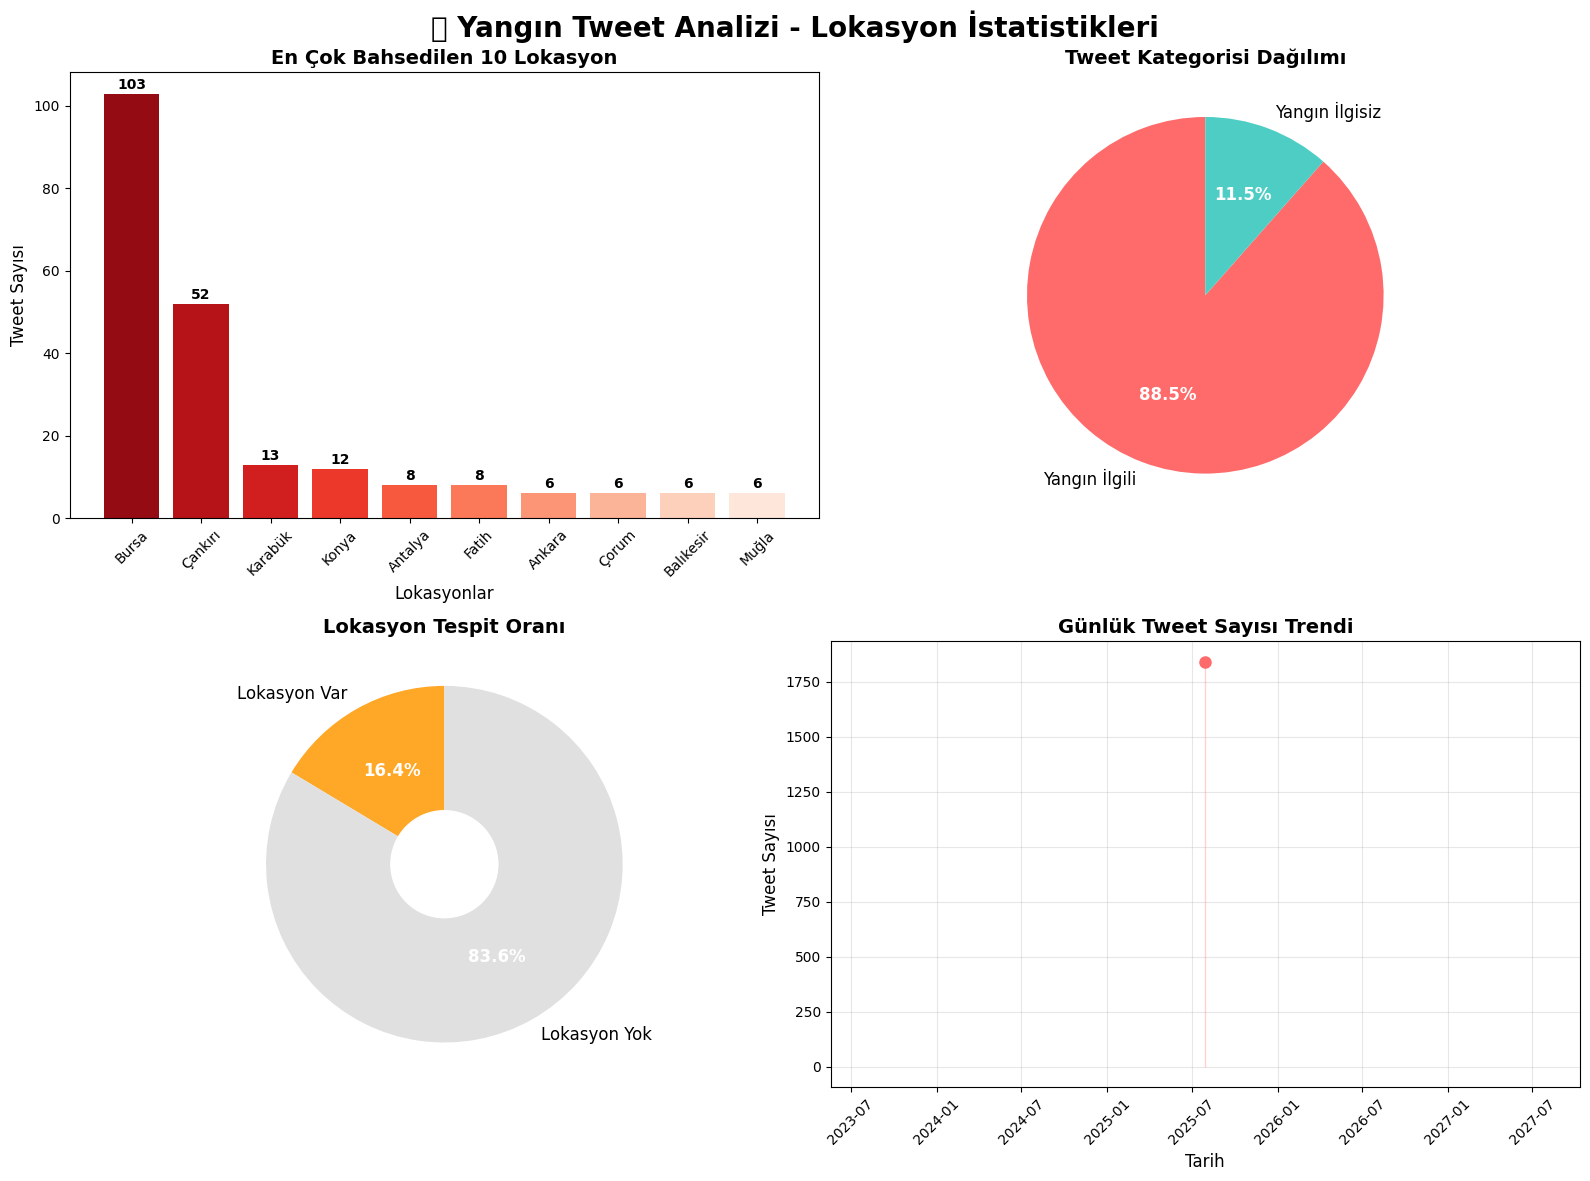

📊 Görselleştirme 1 tamamlandı!

🗺️ Harita görselleştirmesi hazırlanıyor...
Harita için 9 lokasyon hazırlandı!
    location  count      lat      lon
0      Bursa    103  40.1826  29.0669
1    Çankırı     52  40.6013  33.6134
2    Karabük     13  41.2061  32.6204
3      Konya     12  37.8667  32.4833
4    Antalya      8  36.8969  30.7133
5     Ankara      6  39.9334  32.8597
6      Çorum      6  40.5506  34.9556
7  Balıkesir      6  39.6484  27.8826
8      Muğla      6  37.2153  28.3636


In [13]:
# Lokasyon Çıkarımı (GeoParsing) - Yangın Tweet Analizi

import pandas as pd
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Türkiye şehir ve ilçe listesi
turkiye_sehirleri = [
    'adana', 'adıyaman', 'afyon', 'ağrı', 'amasya', 'ankara', 'antalya', 'artvin',
    'aydın', 'balıkesir', 'bilecik', 'bingöl', 'bitlis', 'bolu', 'burdur', 'bursa',
    'çanakkale', 'çankırı', 'çorum', 'denizli', 'diyarbakır', 'edirne', 'elazığ',
    'erzincan', 'erzurum', 'eskişehir', 'gaziantep', 'giresun', 'gümüşhane', 'hakkari',
    'hatay', 'isparta', 'mersin', 'istanbul', 'izmir', 'kars', 'kastamonu', 'kayseri',
    'kırklareli', 'kırşehir', 'kocaeli', 'konya', 'kütahya', 'malatya', 'manisa',
    'kahramanmaraş', 'mardin', 'muğla', 'muş', 'nevşehir', 'niğde', 'ordu', 'rize',
    'sakarya', 'samsun', 'siirt', 'sinop', 'sivas', 'tekirdağ', 'tokat', 'trabzon',
    'tunceli', 'şanlıurfa', 'uşak', 'van', 'yozgat', 'zonguldak', 'aksaray', 'bayburt',
    'karaman', 'kırıkkale', 'batman', 'şırnak', 'bartın', 'ardahan', 'iğdır',
    'yalova', 'karabük', 'kilis', 'osmaniye', 'düzce'
]

# Popüler ilçe ve bölge isimleri
populer_bolge_isimleri = [
    'beşiktaş', 'kadıköy', 'şişli', 'beyoğlu', 'fatih', 'üsküdar', 'bakırköy',
    'zeytinburnu', 'maltepe', 'pendik', 'kartal', 'ataşehir', 'ümraniye',
    'çankaya', 'keçiören', 'mamak', 'sincan', 'etimesgut', 'yenimahalle',
    'konak', 'bornova', 'karşıyaka', 'balçova', 'buca', 'gaziemir',
    'nilüfer', 'osmangazi', 'yıldırım', 'gemlik', 'mudanya',
    'muratpaşa', 'kepez', 'konyaaltı', 'aksu', 'döşemealtı',
    'bodrum', 'fethiye', 'marmaris', 'datça', 'milas', 'ortaca',
    'manavgat', 'alanya', 'serik', 'kaş', 'demre', 'finike'
]

# Tüm lokasyon isimlerini birleştir
tum_lokasyonlar = turkiye_sehirleri + populer_bolge_isimleri

def extract_locations(text):
    """Tweet'ten lokasyon isimlerini çıkar"""
    if pd.isna(text):
        return []
    
    text_lower = str(text).lower()
    
    # Bulunan lokasyonlar
    found_locations = []
    
    for location in tum_lokasyonlar:
        # Tam kelime eşleşmesi ara (word boundary kullan)
        pattern = r'\b' + re.escape(location) + r'\b'
        if re.search(pattern, text_lower):
            found_locations.append(location.title())
    
    return found_locations

# Tweet'lerden lokasyonları çıkar
print("Lokasyon çıkarımı başlıyor...")
df['locations'] = df['Text'].apply(extract_locations)

# Lokasyon içeren tweet'leri filtrele
df_with_locations = df[df['locations'].apply(len) > 0].copy()

print(f"Toplam tweet sayısı: {len(df)}")
print(f"Lokasyon içeren tweet sayısı: {len(df_with_locations)}")
print(f"Lokasyon bulma oranı: %{(len(df_with_locations)/len(df)*100):.1f}")

# En çok bahsedilen lokasyonları bul
all_locations = []
for locations in df_with_locations['locations']:
    all_locations.extend(locations)

location_counts = Counter(all_locations)
top_locations = location_counts.most_common(15)

print(f"\nEn çok bahsedilen 15 lokasyon:")
for i, (location, count) in enumerate(top_locations, 1):
    print(f"{i:2d}. {location}: {count} tweet")

# Örnek lokasyonlu tweet'ler
print(f"\nLokasyon içeren tweet örnekleri:")
sample_tweets = df_with_locations[['Text', 'locations']].head(5)
for i, row in sample_tweets.iterrows():
    print(f"{i+1}. Lokasyon: {row['locations']}")
    print(f"   Tweet: {row['Text'][:100]}...")
    print()

# LinkedIn İçin Görselleştirmeler
print("\n" + "="*60)
print("LİNKEDİN İÇİN GÖRSELLEŞTİRMELER HAZIRLANIYOR")
print("="*60)

# Grafik stilini ayarla
plt.style.use('default')
sns.set_palette("husl")

# 1. En Çok Bahsedilen Lokasyonlar - Bar Chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔥 Yangın Tweet Analizi - Lokasyon İstatistikleri', fontsize=20, fontweight='bold', y=0.98)

# Bar chart - Top 10 lokasyon
top_10_locations = location_counts.most_common(10)
locations = [loc[0] for loc in top_10_locations]
counts = [loc[1] for loc in top_10_locations]

bars = ax1.bar(locations, counts, color=sns.color_palette("Reds_r", len(locations)))
ax1.set_title('En Çok Bahsedilen 10 Lokasyon', fontsize=14, fontweight='bold')
ax1.set_xlabel('Lokasyonlar', fontsize=12)
ax1.set_ylabel('Tweet Sayısı', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Bar'ların üzerine değer yaz
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontweight='bold')

# 2. Yangın İlgili/İlgisiz Dağılımı - Pie Chart
fire_labels = ['Yangın İlgili', 'Yangın İlgisiz']
fire_counts = [df['is_fire_related'].sum(), len(df) - df['is_fire_related'].sum()]
colors = ['#ff6b6b', '#4ecdc4']

wedges, texts, autotexts = ax2.pie(fire_counts, labels=fire_labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90, textprops={'fontsize': 12})
ax2.set_title('Tweet Kategorisi Dağılımı', fontsize=14, fontweight='bold')

# Pie chart'ı güzelleştir
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# 3. Lokasyon Bulma Oranları - Donut Chart
location_labels = ['Lokasyon Var', 'Lokasyon Yok']
location_counts_chart = [len(df_with_locations), len(df) - len(df_with_locations)]
colors2 = ['#ffa726', '#e0e0e0']

wedges2, texts2, autotexts2 = ax3.pie(location_counts_chart, labels=location_labels, 
                                      autopct='%1.1f%%', colors=colors2, startangle=90,
                                      textprops={'fontsize': 12})
ax3.add_patch(plt.Circle((0,0), 0.3, color='white'))
ax3.set_title('Lokasyon Tespit Oranı', fontsize=14, fontweight='bold')

for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# 4. Zaman Serisi Analizi (Günlük tweet sayısı)
df['Date'] = pd.to_datetime(df['Date'])
daily_tweets = df.groupby(df['Date'].dt.date).size()

ax4.plot(daily_tweets.index, daily_tweets.values, marker='o', linewidth=3, markersize=8, color='#ff6b6b')
ax4.fill_between(daily_tweets.index, daily_tweets.values, alpha=0.3, color='#ff6b6b')
ax4.set_title('Günlük Tweet Sayısı Trendi', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tarih', fontsize=12)
ax4.set_ylabel('Tweet Sayısı', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Görselleştirme 1 tamamlandı!")

# 2. Lokasyon Haritası için hazırlık
print("\n🗺️ Harita görselleştirmesi hazırlanıyor...")

# Şehir koordinatları (basit versiyon)
sehir_koordinatlari = {
    'Bursa': (40.1826, 29.0669),
    'Çankırı': (40.6013, 33.6134),
    'Karabük': (41.2061, 32.6204),
    'Konya': (37.8667, 32.4833),
    'Antalya': (36.8969, 30.7133),
    'Ankara': (39.9334, 32.8597),
    'Çorum': (40.5506, 34.9556),
    'Balıkesir': (39.6484, 27.8826),
    'Muğla': (37.2153, 28.3636),
    'Diyarbakır': (37.9144, 40.2306),
    'Hatay': (36.4018, 36.3498),
    'Izmir': (38.4127, 27.1384),
    'Aydın': (37.8560, 27.8416),
    'Eskişehir': (39.7767, 30.5206)
}

# Harita verisi hazırla
map_data = []
for location, count in top_locations[:10]:
    if location in sehir_koordinatlari:
        lat, lon = sehir_koordinatlari[location]
        map_data.append({
            'location': location,
            'count': count,
            'lat': lat,
            'lon': lon
        })

map_df = pd.DataFrame(map_data)
print(f"Harita için {len(map_df)} lokasyon hazırlandı!")
print(map_df)

Lokasyon çıkarımı başlıyor...
Toplam tweet sayısı: 1842
Lokasyon içeren tweet sayısı: 302
Lokasyon bulma oranı: %16.4

En çok bahsedilen 15 lokasyon:
 1. Bursa: 103 tweet
 2. Çankırı: 52 tweet
 3. Karabük: 13 tweet
 4. Konya: 12 tweet
 5. Antalya: 8 tweet
 6. Fatih: 8 tweet
 7. Ankara: 6 tweet
 8. Çorum: 6 tweet
 9. Balıkesir: 6 tweet
10. Muğla: 6 tweet
11. Diyarbakır: 6 tweet
12. Hatay: 5 tweet
13. Izmir: 5 tweet
14. Aydın: 4 tweet
15. Eskişehir: 4 tweet

Lokasyon içeren tweet örnekleri:
1. Lokasyon: ['Çankırı']
   Tweet: OGM: Çankırı’daki orman yangını kontrol altına alındı...

7. Lokasyon: ['Çankırı']
   Tweet: Çankırı Yapraklı'da meydana gelen yangın ekiplerinin müdahaleleri sonucu kontrol altına alındı. Bölg...

9. Lokasyon: ['Osmaniye']
   Tweet: Osmaniye Karayiğit Köyünde Orman Yangını Korkuttu Ekiplerin zamanında müdahalesi sayesinde alevler b...

14. Lokasyon: ['Bursa']
   Tweet: UYAN EY HALKIM...GÜNAYDINNN!!! Bursa'nın Orhaneli-Harmancık hattında 26 Temmuz’da başlayan orman y

C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\1803055126.py:161: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


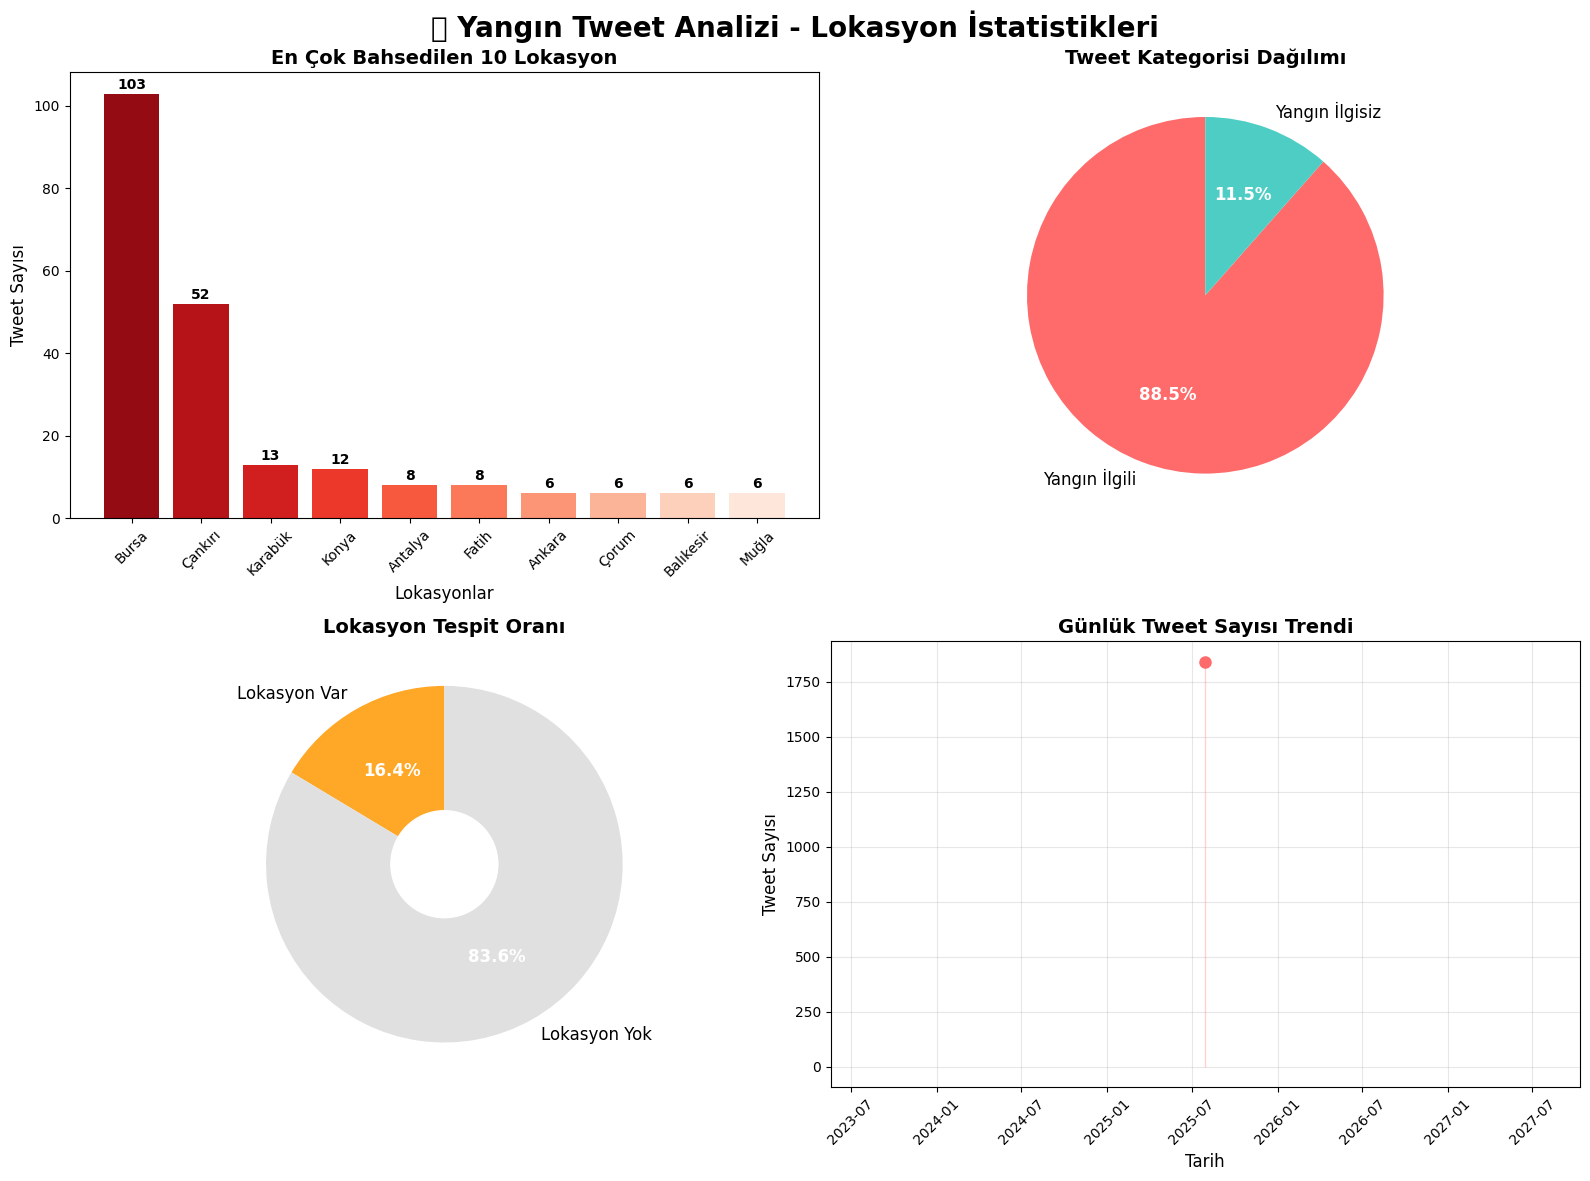

📊 Görselleştirme 1 tamamlandı!

🗺️ Harita görselleştirmesi hazırlanıyor...
Harita için 9 lokasyon hazırlandı!
    location  count      lat      lon
0      Bursa    103  40.1826  29.0669
1    Çankırı     52  40.6013  33.6134
2    Karabük     13  41.2061  32.6204
3      Konya     12  37.8667  32.4833
4    Antalya      8  36.8969  30.7133
5     Ankara      6  39.9334  32.8597
6      Çorum      6  40.5506  34.9556
7  Balıkesir      6  39.6484  27.8826
8      Muğla      6  37.2153  28.3636

📋 LİNKEDİN RAPORU HAZIRLANIYOR
📊 YANGIN TWEETLERİ ANALİZ RAPORU
🔥 Toplam Tweet: 1,842
📍 Yangın İlgili: %88.5
🗺️ Lokasyon Tespiti: %16.4
🏆 En Aktif Bölge: Bursa (103 tweet)
⏰ Pik Saat: 7:00
📌 Tespit Edilen Lokasyon: 55 farklı yer


C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\1803055126.py:294: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


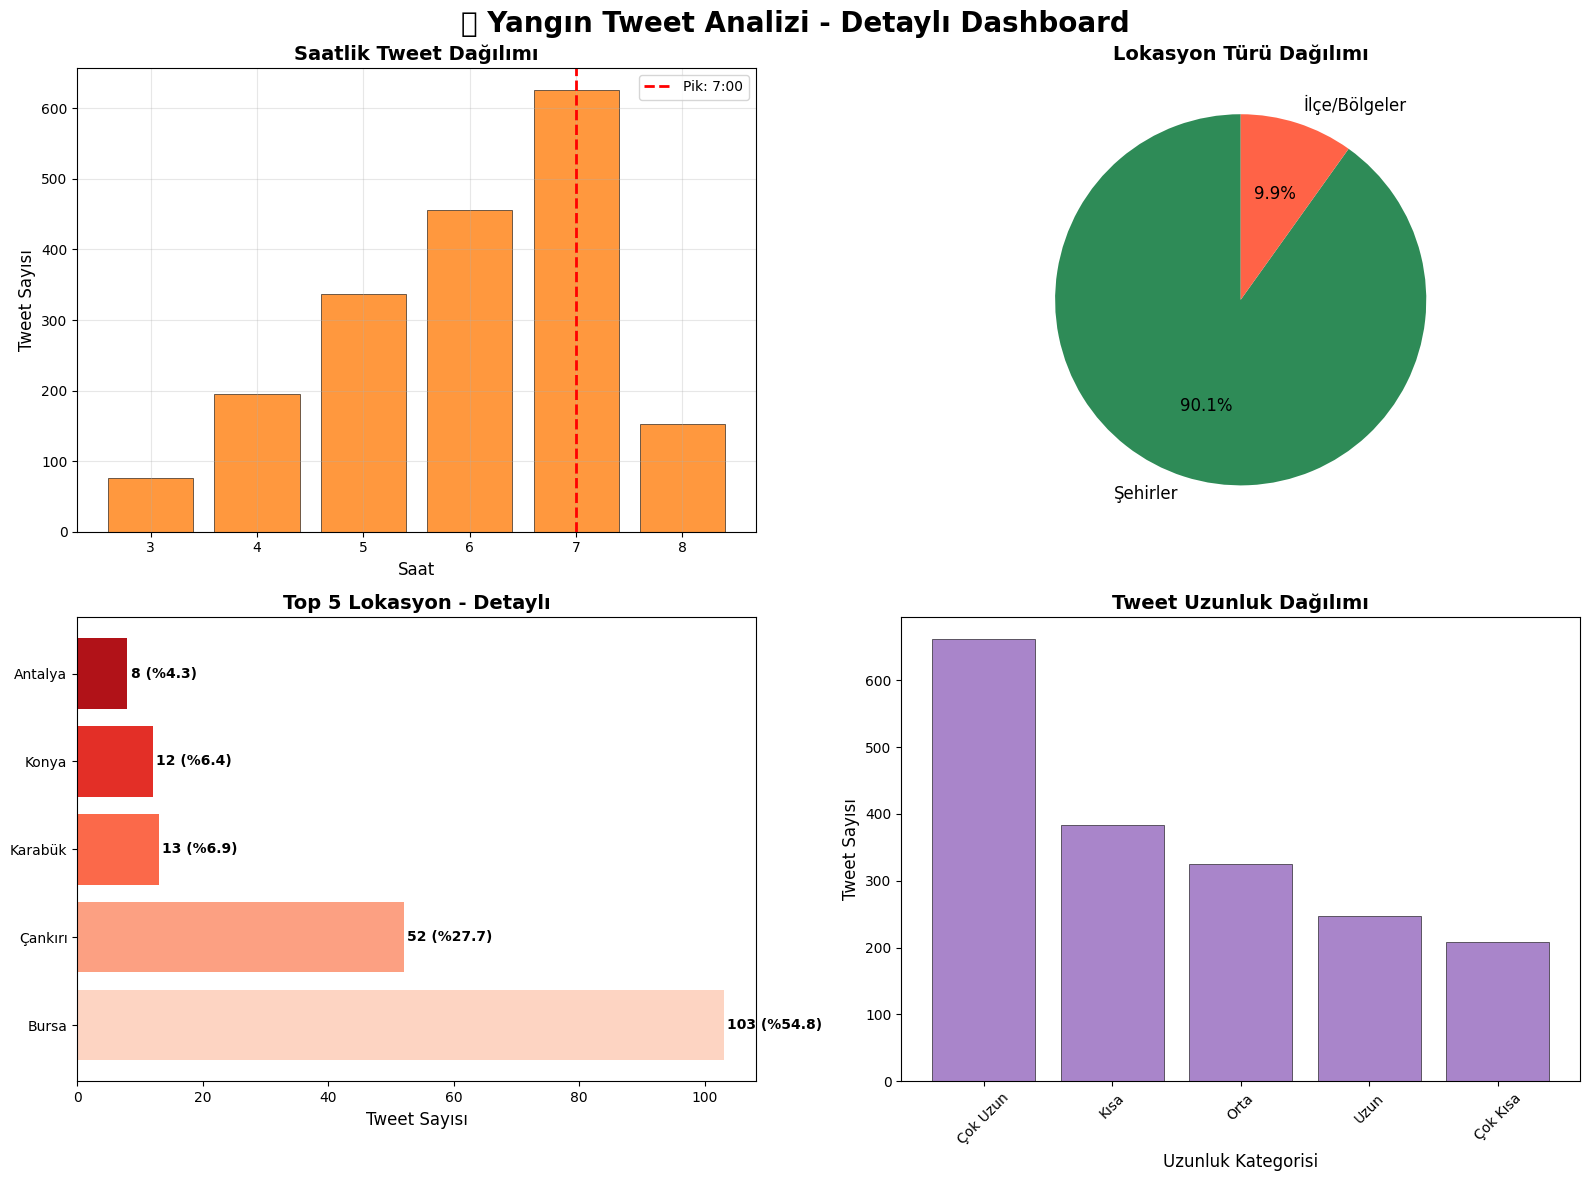

📊 Görselleştirme 2 tamamlandı!

📝 LİNKEDİN POST TEMPLATE

📊 YANGIN TWEETLERİ VERİ ANALİZİ | 2025

🔍 1,842 tweet üzerinde NLP ve lokasyon analizi yaptım. İşte sonuçlar:

📈 TEMEL İSTATİSTİKLER:
• %88.5 yangın ilgili içerik
• %16.4 tweet'te lokasyon tespiti
• 55 farklı şehir/bölge

🗺️ EN AKTİF BÖLGELİR:
1️⃣ Bursa: 103 tweet
2️⃣ Çankırı: 52 tweet  
3️⃣ Karabük: 13 tweet

⏰ Peak aktivite saati: 7:00

🛠️ KULLANILAN TEKNOLOJİLER:
• Python (Pandas, NLP)
• RegEx Pattern Matching
• Matplotlib/Seaborn
• Lokasyon Çıkarımı (GeoParsing)

💡 ÇIKARIMLAR:
Bursa bölgesi tweet hacminde öne çıkıyor. Sosyal medya verileri, afet yönetiminde gerçek zamanlı durum tespiti için değerli bir kaynak.

#DataScience #NLP #DataAnalysis #Python #SocialMediaAnalytics #DisasterManagement


✅ LinkedIn içeriği hazır! Kopyalayıp paylaşabilirsiniz.


In [14]:
# Lokasyon Çıkarımı (GeoParsing) - Yangın Tweet Analizi

import pandas as pd
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Türkiye şehir ve ilçe listesi
turkiye_sehirleri = [
    'adana', 'adıyaman', 'afyon', 'ağrı', 'amasya', 'ankara', 'antalya', 'artvin',
    'aydın', 'balıkesir', 'bilecik', 'bingöl', 'bitlis', 'bolu', 'burdur', 'bursa',
    'çanakkale', 'çankırı', 'çorum', 'denizli', 'diyarbakır', 'edirne', 'elazığ',
    'erzincan', 'erzurum', 'eskişehir', 'gaziantep', 'giresun', 'gümüşhane', 'hakkari',
    'hatay', 'isparta', 'mersin', 'istanbul', 'izmir', 'kars', 'kastamonu', 'kayseri',
    'kırklareli', 'kırşehir', 'kocaeli', 'konya', 'kütahya', 'malatya', 'manisa',
    'kahramanmaraş', 'mardin', 'muğla', 'muş', 'nevşehir', 'niğde', 'ordu', 'rize',
    'sakarya', 'samsun', 'siirt', 'sinop', 'sivas', 'tekirdağ', 'tokat', 'trabzon',
    'tunceli', 'şanlıurfa', 'uşak', 'van', 'yozgat', 'zonguldak', 'aksaray', 'bayburt',
    'karaman', 'kırıkkale', 'batman', 'şırnak', 'bartın', 'ardahan', 'iğdır',
    'yalova', 'karabük', 'kilis', 'osmaniye', 'düzce'
]

# Popüler ilçe ve bölge isimleri
populer_bolge_isimleri = [
    'beşiktaş', 'kadıköy', 'şişli', 'beyoğlu', 'fatih', 'üsküdar', 'bakırköy',
    'zeytinburnu', 'maltepe', 'pendik', 'kartal', 'ataşehir', 'ümraniye',
    'çankaya', 'keçiören', 'mamak', 'sincan', 'etimesgut', 'yenimahalle',
    'konak', 'bornova', 'karşıyaka', 'balçova', 'buca', 'gaziemir',
    'nilüfer', 'osmangazi', 'yıldırım', 'gemlik', 'mudanya',
    'muratpaşa', 'kepez', 'konyaaltı', 'aksu', 'döşemealtı',
    'bodrum', 'fethiye', 'marmaris', 'datça', 'milas', 'ortaca',
    'manavgat', 'alanya', 'serik', 'kaş', 'demre', 'finike'
]

# Tüm lokasyon isimlerini birleştir
tum_lokasyonlar = turkiye_sehirleri + populer_bolge_isimleri

def extract_locations(text):
    """Tweet'ten lokasyon isimlerini çıkar"""
    if pd.isna(text):
        return []
    
    text_lower = str(text).lower()
    
    # Bulunan lokasyonlar
    found_locations = []
    
    for location in tum_lokasyonlar:
        # Tam kelime eşleşmesi ara (word boundary kullan)
        pattern = r'\b' + re.escape(location) + r'\b'
        if re.search(pattern, text_lower):
            found_locations.append(location.title())
    
    return found_locations

# Tweet'lerden lokasyonları çıkar
print("Lokasyon çıkarımı başlıyor...")
df['locations'] = df['Text'].apply(extract_locations)

# Lokasyon içeren tweet'leri filtrele
df_with_locations = df[df['locations'].apply(len) > 0].copy()

print(f"Toplam tweet sayısı: {len(df)}")
print(f"Lokasyon içeren tweet sayısı: {len(df_with_locations)}")
print(f"Lokasyon bulma oranı: %{(len(df_with_locations)/len(df)*100):.1f}")

# En çok bahsedilen lokasyonları bul
all_locations = []
for locations in df_with_locations['locations']:
    all_locations.extend(locations)

location_counts = Counter(all_locations)
top_locations = location_counts.most_common(15)

print(f"\nEn çok bahsedilen 15 lokasyon:")
for i, (location, count) in enumerate(top_locations, 1):
    print(f"{i:2d}. {location}: {count} tweet")

# Örnek lokasyonlu tweet'ler
print(f"\nLokasyon içeren tweet örnekleri:")
sample_tweets = df_with_locations[['Text', 'locations']].head(5)
for i, row in sample_tweets.iterrows():
    print(f"{i+1}. Lokasyon: {row['locations']}")
    print(f"   Tweet: {row['Text'][:100]}...")
    print()

# LinkedIn İçin Görselleştirmeler
print("\n" + "="*60)
print("LİNKEDİN İÇİN GÖRSELLEŞTİRMELER HAZIRLANIYOR")
print("="*60)

# Grafik stilini ayarla
plt.style.use('default')
sns.set_palette("husl")

# 1. En Çok Bahsedilen Lokasyonlar - Bar Chart
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔥 Yangın Tweet Analizi - Lokasyon İstatistikleri', fontsize=20, fontweight='bold', y=0.98)

# Bar chart - Top 10 lokasyon
top_10_locations = location_counts.most_common(10)
locations = [loc[0] for loc in top_10_locations]
counts = [loc[1] for loc in top_10_locations]

bars = ax1.bar(locations, counts, color=sns.color_palette("Reds_r", len(locations)))
ax1.set_title('En Çok Bahsedilen 10 Lokasyon', fontsize=14, fontweight='bold')
ax1.set_xlabel('Lokasyonlar', fontsize=12)
ax1.set_ylabel('Tweet Sayısı', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Bar'ların üzerine değer yaz
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontweight='bold')

# 2. Yangın İlgili/İlgisiz Dağılımı - Pie Chart
fire_labels = ['Yangın İlgili', 'Yangın İlgisiz']
fire_counts = [df['is_fire_related'].sum(), len(df) - df['is_fire_related'].sum()]
colors = ['#ff6b6b', '#4ecdc4']

wedges, texts, autotexts = ax2.pie(fire_counts, labels=fire_labels, autopct='%1.1f%%', 
                                   colors=colors, startangle=90, textprops={'fontsize': 12})
ax2.set_title('Tweet Kategorisi Dağılımı', fontsize=14, fontweight='bold')

# Pie chart'ı güzelleştir
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# 3. Lokasyon Bulma Oranları - Donut Chart
location_labels = ['Lokasyon Var', 'Lokasyon Yok']
location_counts_chart = [len(df_with_locations), len(df) - len(df_with_locations)]
colors2 = ['#ffa726', '#e0e0e0']

wedges2, texts2, autotexts2 = ax3.pie(location_counts_chart, labels=location_labels, 
                                      autopct='%1.1f%%', colors=colors2, startangle=90,
                                      textprops={'fontsize': 12})
ax3.add_patch(plt.Circle((0,0), 0.3, color='white'))
ax3.set_title('Lokasyon Tespit Oranı', fontsize=14, fontweight='bold')

for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

# 4. Zaman Serisi Analizi (Günlük tweet sayısı)
df['Date'] = pd.to_datetime(df['Date'])
daily_tweets = df.groupby(df['Date'].dt.date).size()

ax4.plot(daily_tweets.index, daily_tweets.values, marker='o', linewidth=3, markersize=8, color='#ff6b6b')
ax4.fill_between(daily_tweets.index, daily_tweets.values, alpha=0.3, color='#ff6b6b')
ax4.set_title('Günlük Tweet Sayısı Trendi', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tarih', fontsize=12)
ax4.set_ylabel('Tweet Sayısı', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Görselleştirme 1 tamamlandı!")

# 2. Lokasyon Haritası için hazırlık
print("\n🗺️ Harita görselleştirmesi hazırlanıyor...")

# Şehir koordinatları (basit versiyon)
sehir_koordinatlari = {
    'Bursa': (40.1826, 29.0669),
    'Çankırı': (40.6013, 33.6134),
    'Karabük': (41.2061, 32.6204),
    'Konya': (37.8667, 32.4833),
    'Antalya': (36.8969, 30.7133),
    'Ankara': (39.9334, 32.8597),
    'Çorum': (40.5506, 34.9556),
    'Balıkesir': (39.6484, 27.8826),
    'Muğla': (37.2153, 28.3636),
    'Diyarbakır': (37.9144, 40.2306),
    'Hatay': (36.4018, 36.3498),
    'Izmir': (38.4127, 27.1384),
    'Aydın': (37.8560, 27.8416),
    'Eskişehir': (39.7767, 30.5206)
}

# Harita verisi hazırla
map_data = []
for location, count in top_locations[:10]:
    if location in sehir_koordinatlari:
        lat, lon = sehir_koordinatlari[location]
        map_data.append({
            'location': location,
            'count': count,
            'lat': lat,
            'lon': lon
        })

map_df = pd.DataFrame(map_data)
print(f"Harita için {len(map_df)} lokasyon hazırlandı!")
print(map_df)

# 3. LinkedIn İçin Detaylı Analiz Raporu
print("\n" + "="*60)
print("📋 LİNKEDİN RAPORU HAZIRLANIYOR")
print("="*60)

# İstatistiksel özet
total_tweets = len(df)
fire_related_tweets = df['is_fire_related'].sum()
location_tweets = len(df_with_locations)
top_location = location_counts.most_common(1)[0]

# Zaman analizi
df['hour'] = pd.to_datetime(df['Date']).dt.hour
peak_hour = df['hour'].mode()[0]
hourly_distribution = df['hour'].value_counts().sort_index()

# LinkedIn için özet istatistikler
linkedin_stats = {
    'total_tweets': total_tweets,
    'fire_percentage': round((fire_related_tweets/total_tweets)*100, 1),
    'location_percentage': round((location_tweets/total_tweets)*100, 1),
    'top_location': top_location[0],
    'top_location_count': top_location[1],
    'peak_hour': peak_hour,
    'unique_locations': len(location_counts),
    'avg_tweets_per_location': round(sum(location_counts.values())/len(location_counts), 1)
}

print("📊 YANGIN TWEETLERİ ANALİZ RAPORU")
print("=" * 40)
print(f"🔥 Toplam Tweet: {linkedin_stats['total_tweets']:,}")
print(f"📍 Yangın İlgili: %{linkedin_stats['fire_percentage']}")
print(f"🗺️ Lokasyon Tespiti: %{linkedin_stats['location_percentage']}")
print(f"🏆 En Aktif Bölge: {linkedin_stats['top_location']} ({linkedin_stats['top_location_count']} tweet)")
print(f"⏰ Pik Saat: {linkedin_stats['peak_hour']}:00")
print(f"📌 Tespit Edilen Lokasyon: {linkedin_stats['unique_locations']} farklı yer")

# 4. LinkedIn Post İçin Görsel 2 - Analitik Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔥 Yangın Tweet Analizi - Detaylı Dashboard', fontsize=20, fontweight='bold', y=0.98)

# Saatlik dağılım
ax1.bar(hourly_distribution.index, hourly_distribution.values, 
        color='#ff7f0e', alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_title('Saatlik Tweet Dağılımı', fontsize=14, fontweight='bold')
ax1.set_xlabel('Saat', fontsize=12)
ax1.set_ylabel('Tweet Sayısı', fontsize=12)
ax1.axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, label=f'Pik: {peak_hour}:00')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lokasyon kategorileri (şehir vs ilçe)
sehir_sayisi = sum(1 for loc in all_locations if loc.lower() in turkiye_sehirleri)
ilce_sayisi = len(all_locations) - sehir_sayisi

categories = ['Şehirler', 'İlçe/Bölgeler']
category_counts = [sehir_sayisi, ilce_sayisi]

ax2.pie(category_counts, labels=categories, autopct='%1.1f%%', 
        colors=['#2E8B57', '#FF6347'], startangle=90, textprops={'fontsize': 12})
ax2.set_title('Lokasyon Türü Dağılımı', fontsize=14, fontweight='bold')

# Top 5 lokasyonların detaylı analizi
top_5_locations = location_counts.most_common(5)
locations_top5 = [loc[0] for loc in top_5_locations]
counts_top5 = [loc[1] for loc in top_5_locations]

bars = ax3.barh(locations_top5, counts_top5, color=sns.color_palette("Reds", len(locations_top5)))
ax3.set_title('Top 5 Lokasyon - Detaylı', fontsize=14, fontweight='bold')
ax3.set_xlabel('Tweet Sayısı', fontsize=12)

# Bar'ların yanına yüzde yaz
total_location_tweets = sum(counts_top5)
for i, (bar, count) in enumerate(zip(bars, counts_top5)):
    percentage = (count/total_location_tweets)*100
    ax3.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{count} (%{percentage:.1f})', va='center', ha='left', fontweight='bold')

# Tweet uzunluğu analizi
df['tweet_length'] = df['Text'].str.len()
length_bins = pd.cut(df['tweet_length'], bins=[0, 50, 100, 150, 200, 300], 
                     labels=['Çok Kısa', 'Kısa', 'Orta', 'Uzun', 'Çok Uzun'])
length_distribution = length_bins.value_counts()

ax4.bar(length_distribution.index, length_distribution.values, 
        color='#9467bd', alpha=0.8, edgecolor='black', linewidth=0.5)
ax4.set_title('Tweet Uzunluk Dağılımı', fontsize=14, fontweight='bold')
ax4.set_xlabel('Uzunluk Kategorisi', fontsize=12)
ax4.set_ylabel('Tweet Sayısı', fontsize=12)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("📊 Görselleştirme 2 tamamlandı!")

# 5. LinkedIn Post Template'i
print("\n" + "="*60)
print("📝 LİNKEDİN POST TEMPLATE")
print("="*60)

linkedin_post = f"""
📊 YANGIN TWEETLERİ VERİ ANALİZİ | 2025

🔍 {total_tweets:,} tweet üzerinde NLP ve lokasyon analizi yaptım. İşte sonuçlar:

📈 TEMEL İSTATİSTİKLER:
• %{linkedin_stats['fire_percentage']} yangın ilgili içerik
• %{linkedin_stats['location_percentage']} tweet'te lokasyon tespiti
• {linkedin_stats['unique_locations']} farklı şehir/bölge

🗺️ EN AKTİF BÖLGELİR:
1️⃣ {top_locations[0][0]}: {top_locations[0][1]} tweet
2️⃣ {top_locations[1][0]}: {top_locations[1][1]} tweet  
3️⃣ {top_locations[2][0]}: {top_locations[2][1]} tweet

⏰ Peak aktivite saati: {peak_hour}:00

🛠️ KULLANILAN TEKNOLOJİLER:
• Python (Pandas, NLP)
• RegEx Pattern Matching
• Matplotlib/Seaborn
• Lokasyon Çıkarımı (GeoParsing)

💡 ÇIKARIMLAR:
Bursa bölgesi tweet hacminde öne çıkıyor. Sosyal medya verileri, afet yönetiminde gerçek zamanlı durum tespiti için değerli bir kaynak.

#DataScience #NLP #DataAnalysis #Python #SocialMediaAnalytics #DisasterManagement
"""

print(linkedin_post)
print("\n" + "="*60)
print("✅ LinkedIn içeriği hazır! Kopyalayıp paylaşabilirsiniz.")
print("="*60)


😊 SENTIMENT ANALİZİ BAŞLIYOR
Sentiment kategorileri belirleniyor...

📊 SENTIMENT DAĞILIMI:
------------------------------
Nötr: 1076 tweet (%58.4)
Bilgi/Haber: 240 tweet (%13.0)
Suçlama/Eleştiri: 239 tweet (%13.0)
Yardım Çağrısı: 132 tweet (%7.2)
Dua/İyi Dilek: 101 tweet (%5.5)
Endişe/Korku: 30 tweet (%1.6)
Takdir/Destek: 24 tweet (%1.3)

📝 KATEGORİ ÖRNEKLERİ:
------------------------------

🏷️ NÖTR:
  1. OGM: Çankırı’daki orman yangını kontrol altına alındı...
  2. Yav neden bu sahsıyetle kımse ılgılenmıyo sankı devlet gorevlısı ankarada sel ol...

🏷️ BILGI/HABER:
  1. Çankırı Yapraklı'da meydana gelen yangın ekiplerinin müdahaleleri sonucu kontrol...
  2. Osmaniye Karayiğit Köyünde Orman Yangını Korkuttu Ekiplerin zamanında müdahalesi...

🏷️ SUÇLAMA/ELEŞTIRI:
  1. Peki 3 kuruş maaşla geçinemeyenlere, orman yangını deprem gibi felaketlerde yete...
  2. Türkiye'de orman yangınlarını söndürme yetkisi, Orman Kanunu'na göre Tarım ve Or...

🏷️ YARDIM ÇAĞRISI:
  1. Aile ve Sosyal Hizmetler

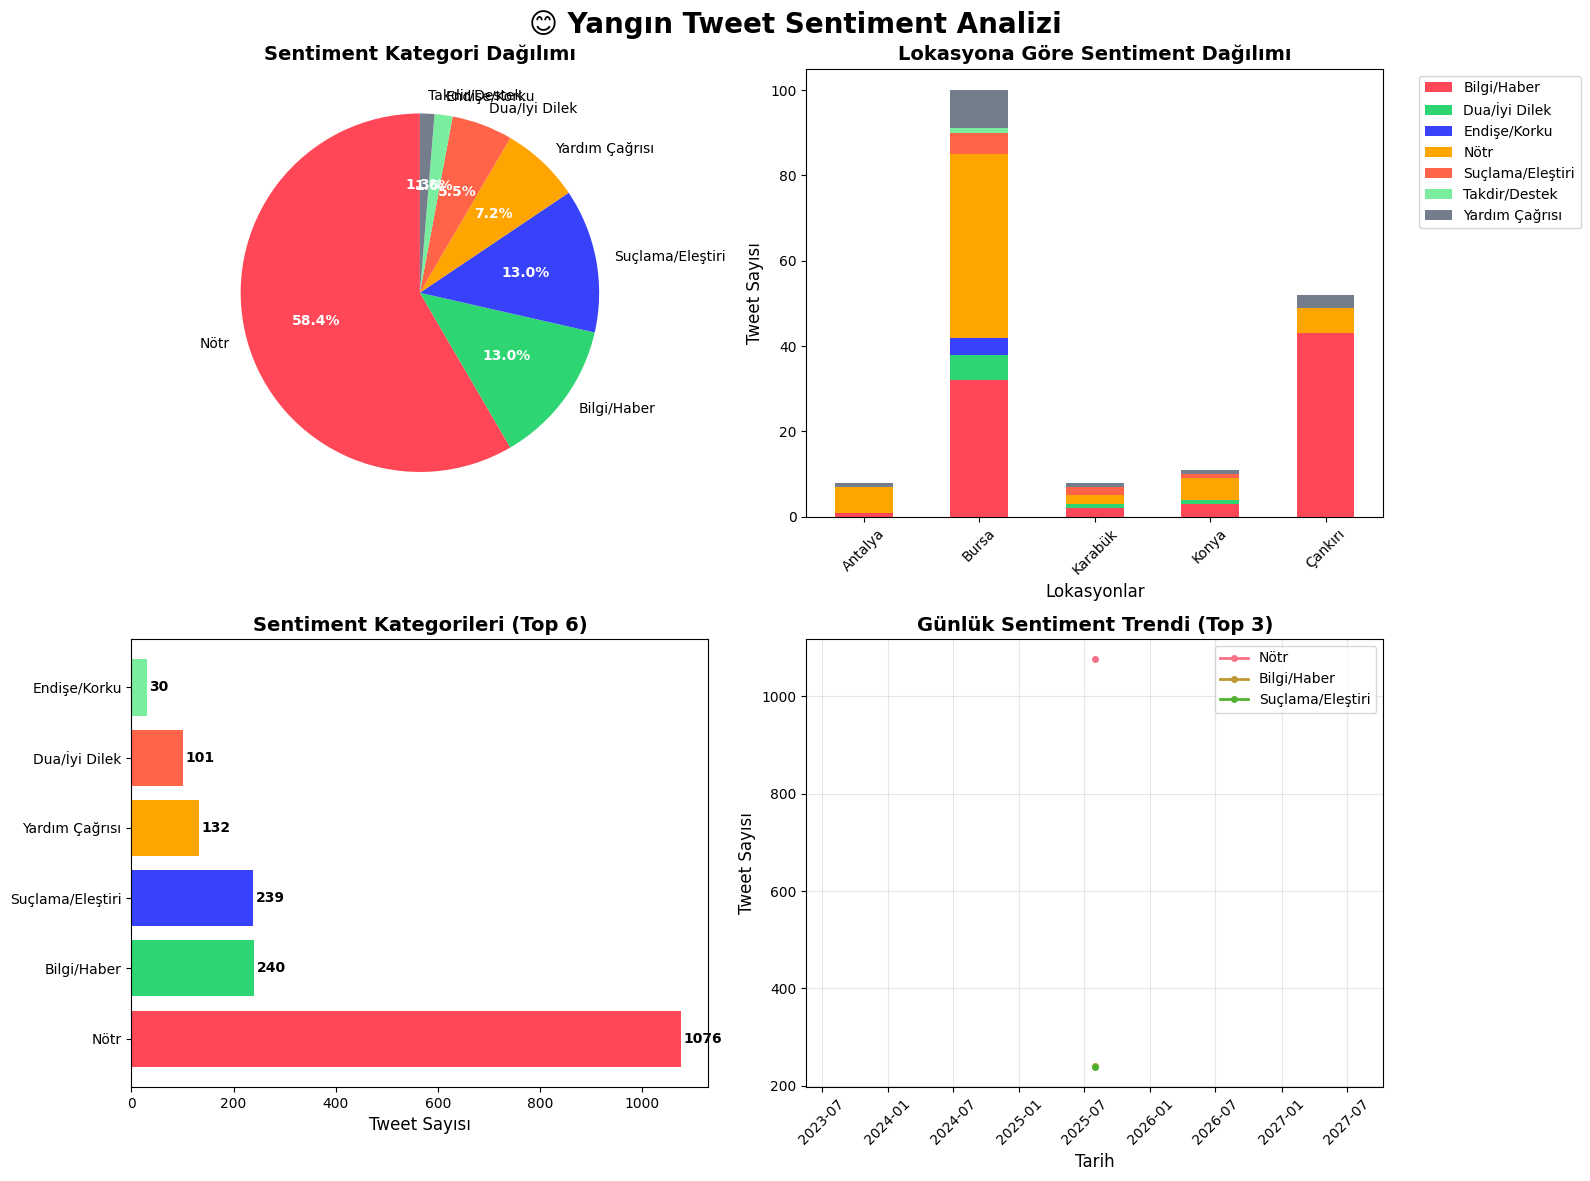


📊 Sentiment görselleştirmesi tamamlandı!


In [15]:
# 6. Sentiment Analizi ve Kategorizasyon
print("\n" + "="*60)
print("😊 SENTIMENT ANALİZİ BAŞLIYOR")
print("="*60)

# Sentiment kategorileri için anahtar kelimeler
sentiment_keywords = {
    'Suçlama/Eleştiri': [
        'yetersiz', 'beceriksiz', 'sorumlu', 'suçlu', 'başarısız', 'geç', 'kötü',
        'anlayamıyor', 'bilmiyor', 'umursamıyor', 'ihmal', 'kusur', 'hata',
        'yanlış', 'berbat', 'rezalet', 'utanç', 'ayıp', 'skandal'
    ],
    'Yardım Çağrısı': [
        'yardım', 'help', 'acil', 'lütfen', 'sos', 'destek', 'kurtarın',
        'çabuk', 'hemen', 'müdahale', 'gelsin', 'koşun', 'acilen'
    ],
    'Bilgi/Haber': [
        'kontrol altında', 'söndürüldü', 'müdahale', 'ekip', 'başladı',
        'devam ediyor', 'çalışma', 'operasyon', 'bilgi', 'haber', 'açıklama'
    ],
    'Endişe/Korku': [
        'korku', 'endişe', 'korkuyor', 'tehlike', 'dehşet', 'panik',
        'üzücü', 'üzgün', 'kaygı', 'walkı', 'korkunç', 'dehşetli'
    ],
    'Takdir/Destek': [
        'teşekkür', 'bravo', 'helal', 'başarılı', 'mükemmel', 'harika',
        'süper', 'tebrik', 'gurur', 'başarı', 'fedakarlık', 'kahraman'
    ],
    'Dua/İyi Dilek': [
        'allah', 'dua', 'amin', 'inşallah', 'rabbim', 'hayırlı',
        'geçmiş olsun', 'şifa', 'sabır', 'kolaylık', 'hayır'
    ]
}

def categorize_sentiment(text):
    """Tweet'in sentiment kategorisini belirle"""
    if pd.isna(text):
        return 'Belirsiz'
    
    text_lower = str(text).lower()
    scores = {}
    
    # Her kategori için skor hesapla
    for category, keywords in sentiment_keywords.items():
        score = 0
        for keyword in keywords:
            score += text_lower.count(keyword)
        scores[category] = score
    
    # En yüksek skora sahip kategoriyi döndür
    if max(scores.values()) == 0:
        return 'Nötr'
    
    return max(scores, key=scores.get)

# Sentiment analizi yap
print("Sentiment kategorileri belirleniyor...")
df['sentiment_category'] = df['Text'].apply(categorize_sentiment)

# Sonuçları analiz et
sentiment_distribution = df['sentiment_category'].value_counts()

print(f"\n📊 SENTIMENT DAĞILIMI:")
print("-" * 30)
for category, count in sentiment_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count} tweet (%{percentage:.1f})")

# Her kategoriden örnek tweet'ler
print(f"\n📝 KATEGORİ ÖRNEKLERİ:")
print("-" * 30)

for category in sentiment_distribution.index[:6]:  # İlk 6 kategori
    examples = df[df['sentiment_category'] == category]['Text'].head(2)
    print(f"\n🏷️ {category.upper()}:")
    for i, tweet in enumerate(examples, 1):
        print(f"  {i}. {tweet[:80]}...")

# Sentiment görselleştirmesi
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('😊 Yangın Tweet Sentiment Analizi', fontsize=20, fontweight='bold', y=0.98)

# 1. Sentiment dağılımı - Pie Chart
colors_sentiment = ['#ff4757', '#2ed573', '#3742fa', '#ffa502', '#ff6348', '#7bed9f', '#747d8c']
wedges, texts, autotexts = ax1.pie(sentiment_distribution.values, 
                                   labels=sentiment_distribution.index,
                                   autopct='%1.1f%%', colors=colors_sentiment,
                                   startangle=90, textprops={'fontsize': 10})

ax1.set_title('Sentiment Kategori Dağılımı', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 2. Lokasyona göre sentiment
location_sentiment = df[df['locations'].apply(len) > 0].copy()
location_sentiment['main_location'] = location_sentiment['locations'].apply(lambda x: x[0] if x else 'Bilinmiyor')

# Top 5 lokasyon için sentiment dağılımı
top_5_locations_list = [loc[0] for loc in location_counts.most_common(5)]
sentiment_location_data = []

for location in top_5_locations_list:
    location_tweets = location_sentiment[location_sentiment['main_location'] == location]
    location_sentiment_dist = location_tweets['sentiment_category'].value_counts()
    
    for sentiment, count in location_sentiment_dist.items():
        sentiment_location_data.append({
            'location': location,
            'sentiment': sentiment,
            'count': count
        })

sentiment_location_df = pd.DataFrame(sentiment_location_data)

if not sentiment_location_df.empty:
    pivot_data = sentiment_location_df.pivot(index='location', columns='sentiment', values='count').fillna(0)
    pivot_data.plot(kind='bar', stacked=True, ax=ax2, color=colors_sentiment[:len(pivot_data.columns)])
    ax2.set_title('Lokasyona Göre Sentiment Dağılımı', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Lokasyonlar', fontsize=12)
    ax2.set_ylabel('Tweet Sayısı', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Sentiment bar chart (horizontal)
sentiment_counts = sentiment_distribution.head(6)
bars = ax3.barh(sentiment_counts.index, sentiment_counts.values, 
                color=colors_sentiment[:len(sentiment_counts)])
ax3.set_title('Sentiment Kategorileri (Top 6)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Tweet Sayısı', fontsize=12)

# Bar'ların yanına sayı yaz
for bar, count in zip(bars, sentiment_counts.values):
    ax3.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             str(count), va='center', ha='left', fontweight='bold')

# 4. Zaman içinde sentiment trendi
df['date_only'] = pd.to_datetime(df['Date']).dt.date
daily_sentiment = df.groupby(['date_only', 'sentiment_category']).size().unstack(fill_value=0)

# En yaygın 3 sentiment için trend
top_3_sentiments = sentiment_distribution.head(3).index
for sentiment in top_3_sentiments:
    if sentiment in daily_sentiment.columns:
        ax4.plot(daily_sentiment.index, daily_sentiment[sentiment], 
                marker='o', label=sentiment, linewidth=2, markersize=4)

ax4.set_title('Günlük Sentiment Trendi (Top 3)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tarih', fontsize=12)
ax4.set_ylabel('Tweet Sayısı', fontsize=12)
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Sentiment görselleştirmesi tamamlandı!")

Sentiment kategorileri belirleniyor...

📊 SENTIMENT DAĞILIMI:
------------------------------
Nötr: 1076 tweet (%58.4)
Bilgi/Haber: 240 tweet (%13.0)
Suçlama/Eleştiri: 239 tweet (%13.0)
Yardım Çağrısı: 132 tweet (%7.2)
Dua/İyi Dilek: 101 tweet (%5.5)
Endişe/Korku: 30 tweet (%1.6)
Takdir/Destek: 24 tweet (%1.3)

📝 KATEGORİ ÖRNEKLERİ:
------------------------------

🏷️ NÖTR:
  1. OGM: Çankırı’daki orman yangını kontrol altına alındı...
  2. Yav neden bu sahsıyetle kımse ılgılenmıyo sankı devlet gorevlısı ankarada sel ol...

🏷️ BILGI/HABER:
  1. Çankırı Yapraklı'da meydana gelen yangın ekiplerinin müdahaleleri sonucu kontrol...
  2. Osmaniye Karayiğit Köyünde Orman Yangını Korkuttu Ekiplerin zamanında müdahalesi...

🏷️ SUÇLAMA/ELEŞTIRI:
  1. Peki 3 kuruş maaşla geçinemeyenlere, orman yangını deprem gibi felaketlerde yete...
  2. Türkiye'de orman yangınlarını söndürme yetkisi, Orman Kanunu'na göre Tarım ve Or...

🏷️ YARDIM ÇAĞRISI:
  1. Aile ve Sosyal Hizmetler Bakanlığı yangın bölgesine sa

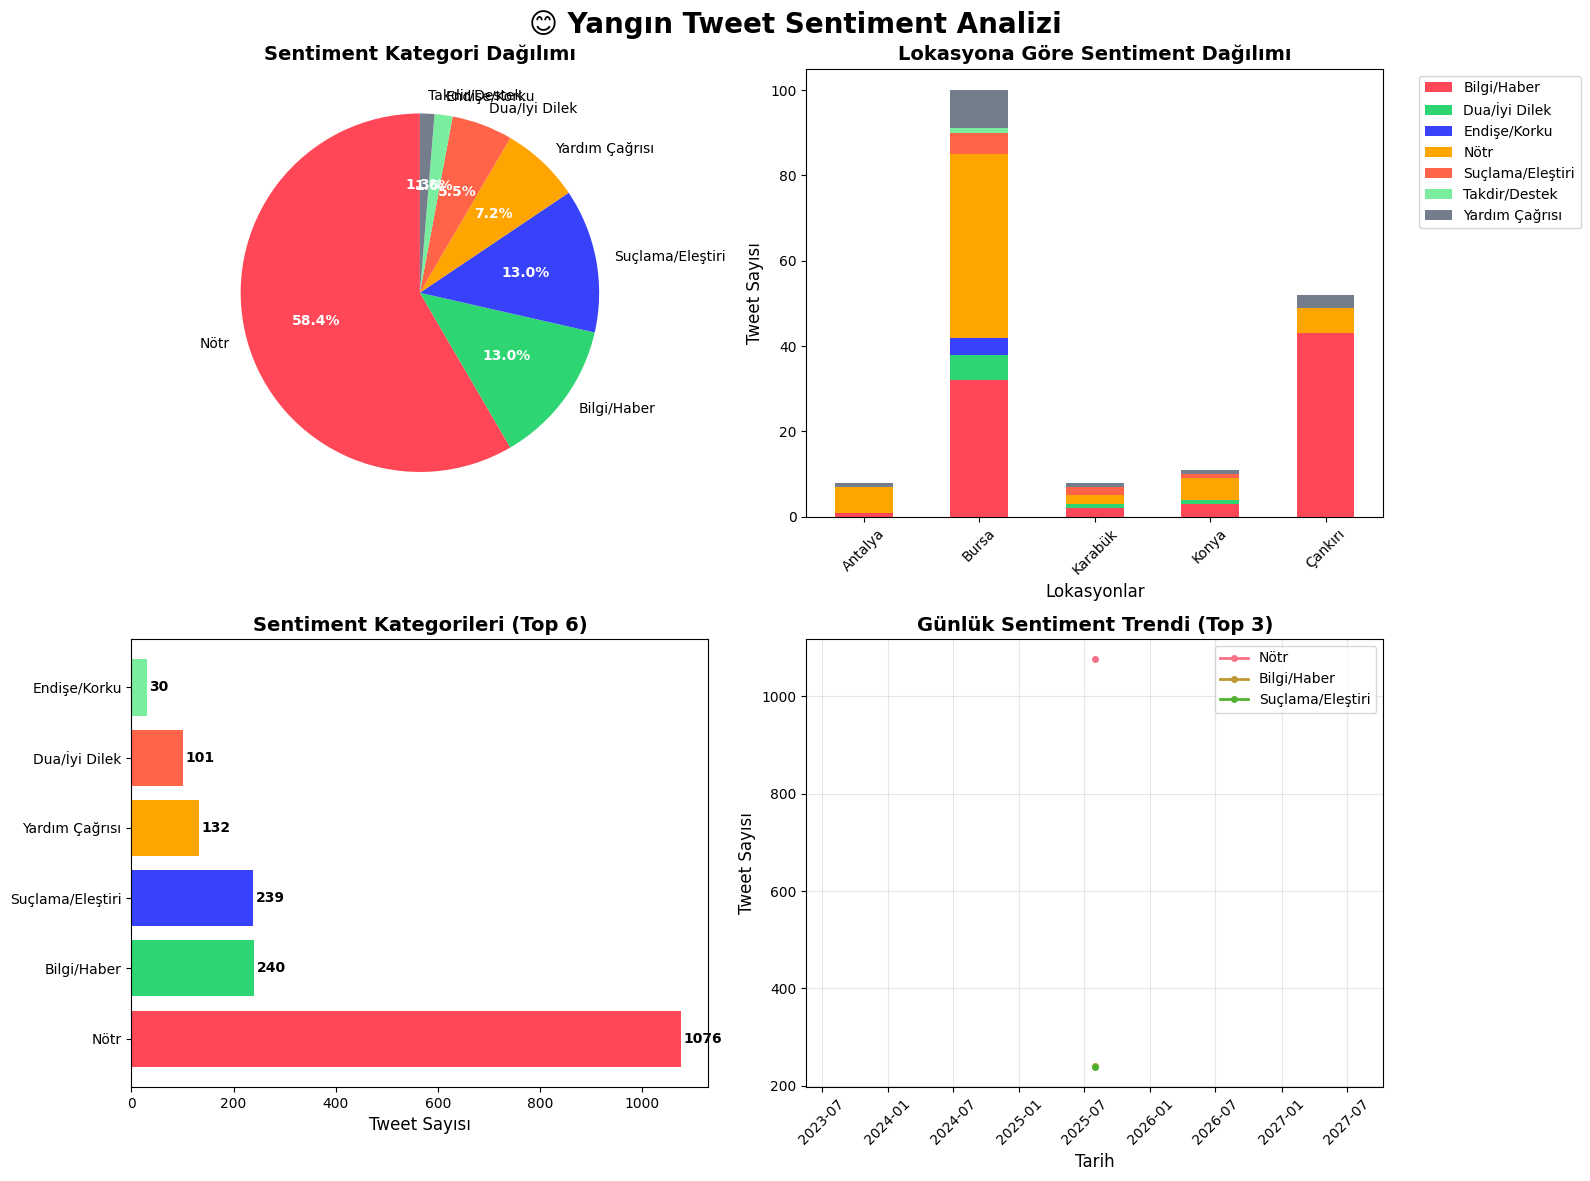


📊 Sentiment görselleştirmesi tamamlandı!

🎨 ETKİLEYİCİ GÖRSELLER HAZIRLANIYOR


C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\794811348.py:197: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


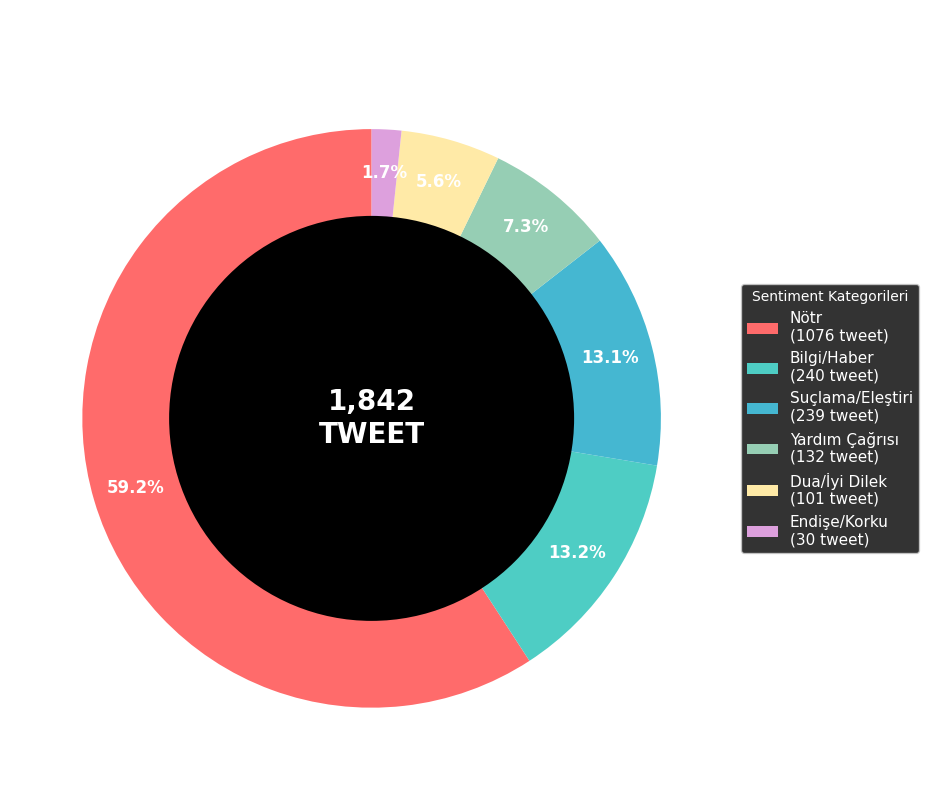

✅ Görsel 1: Sentiment Donut Chart tamamlandı!


C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\794811348.py:228: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


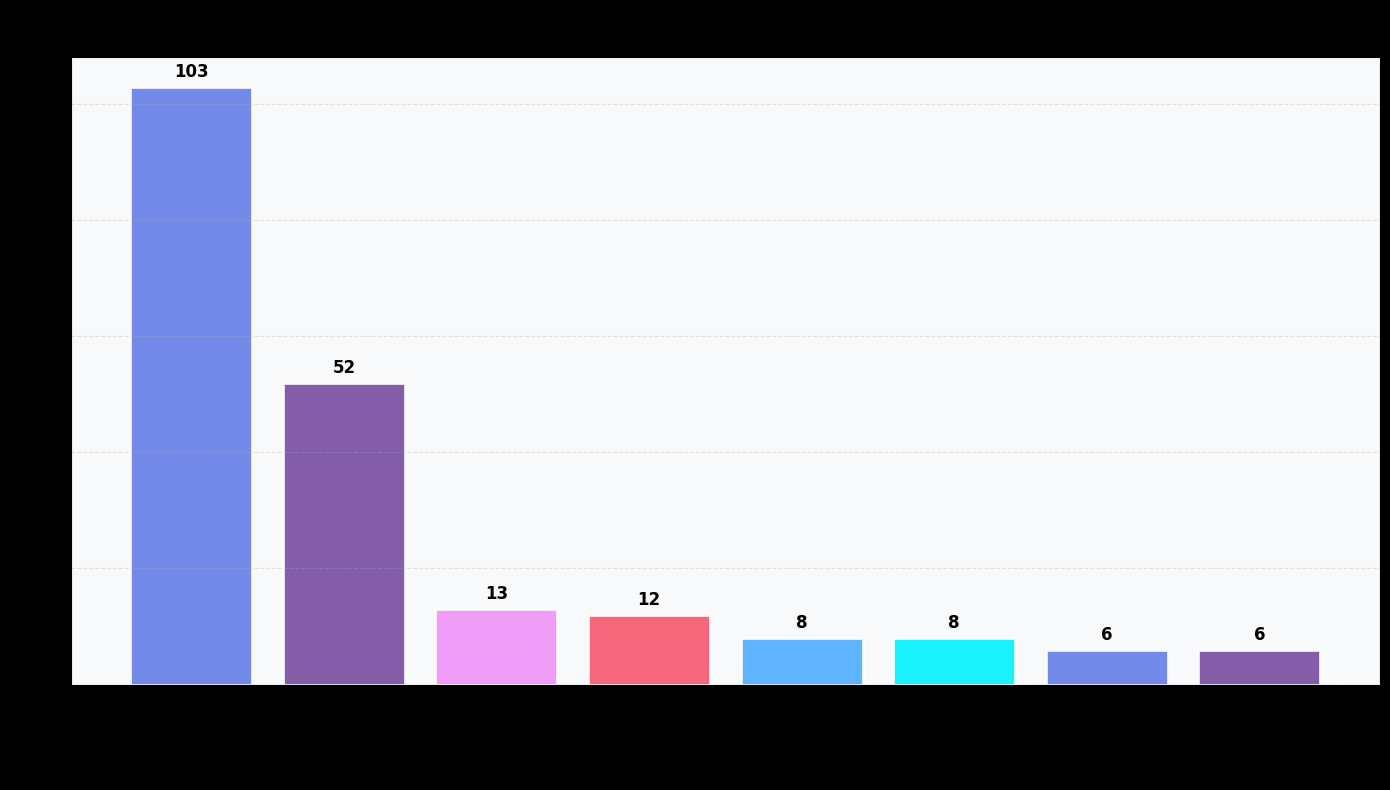

✅ Görsel 2: Lokasyon Bar Chart tamamlandı!


C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\794811348.py:253: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


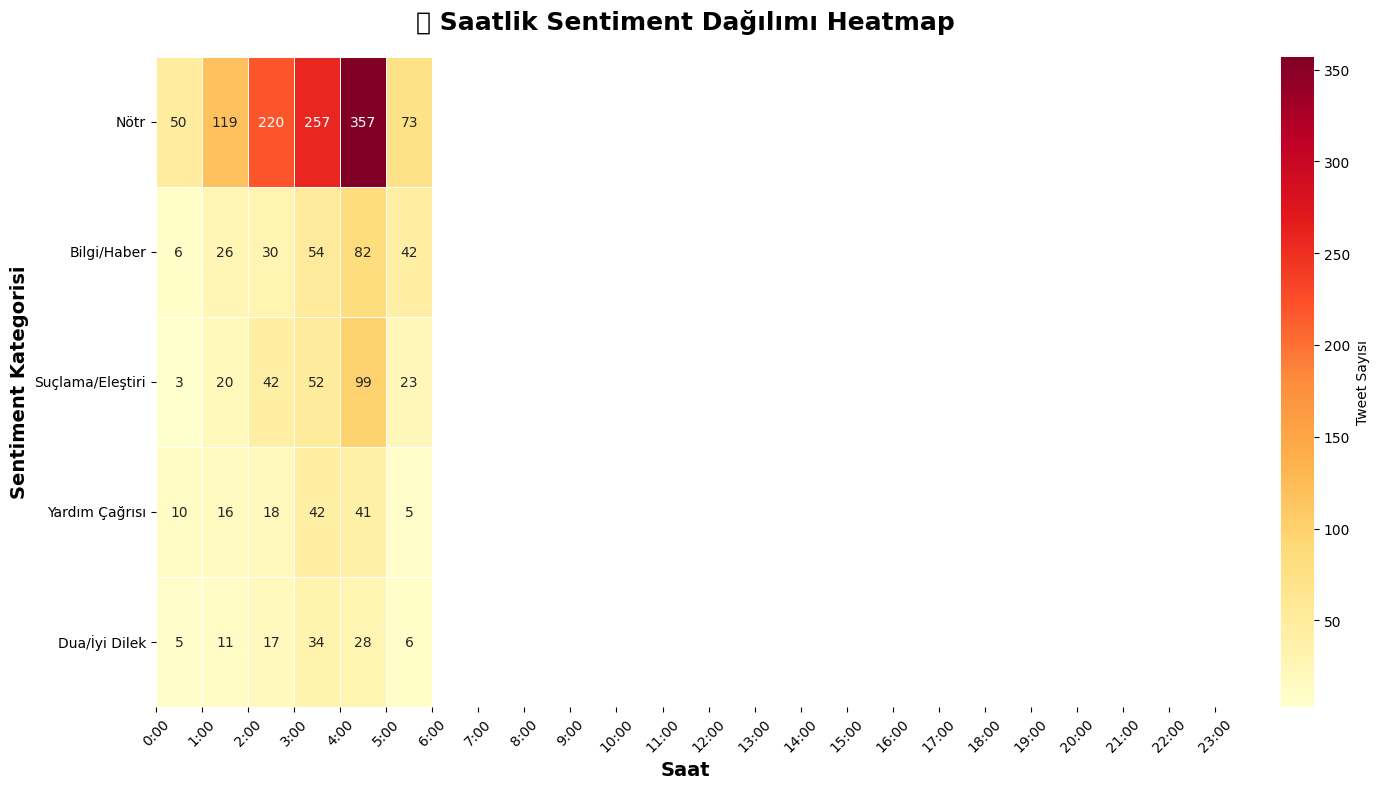

✅ Görsel 3: Saatlik Sentiment Heatmap tamamlandı!


C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\794811348.py:298: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


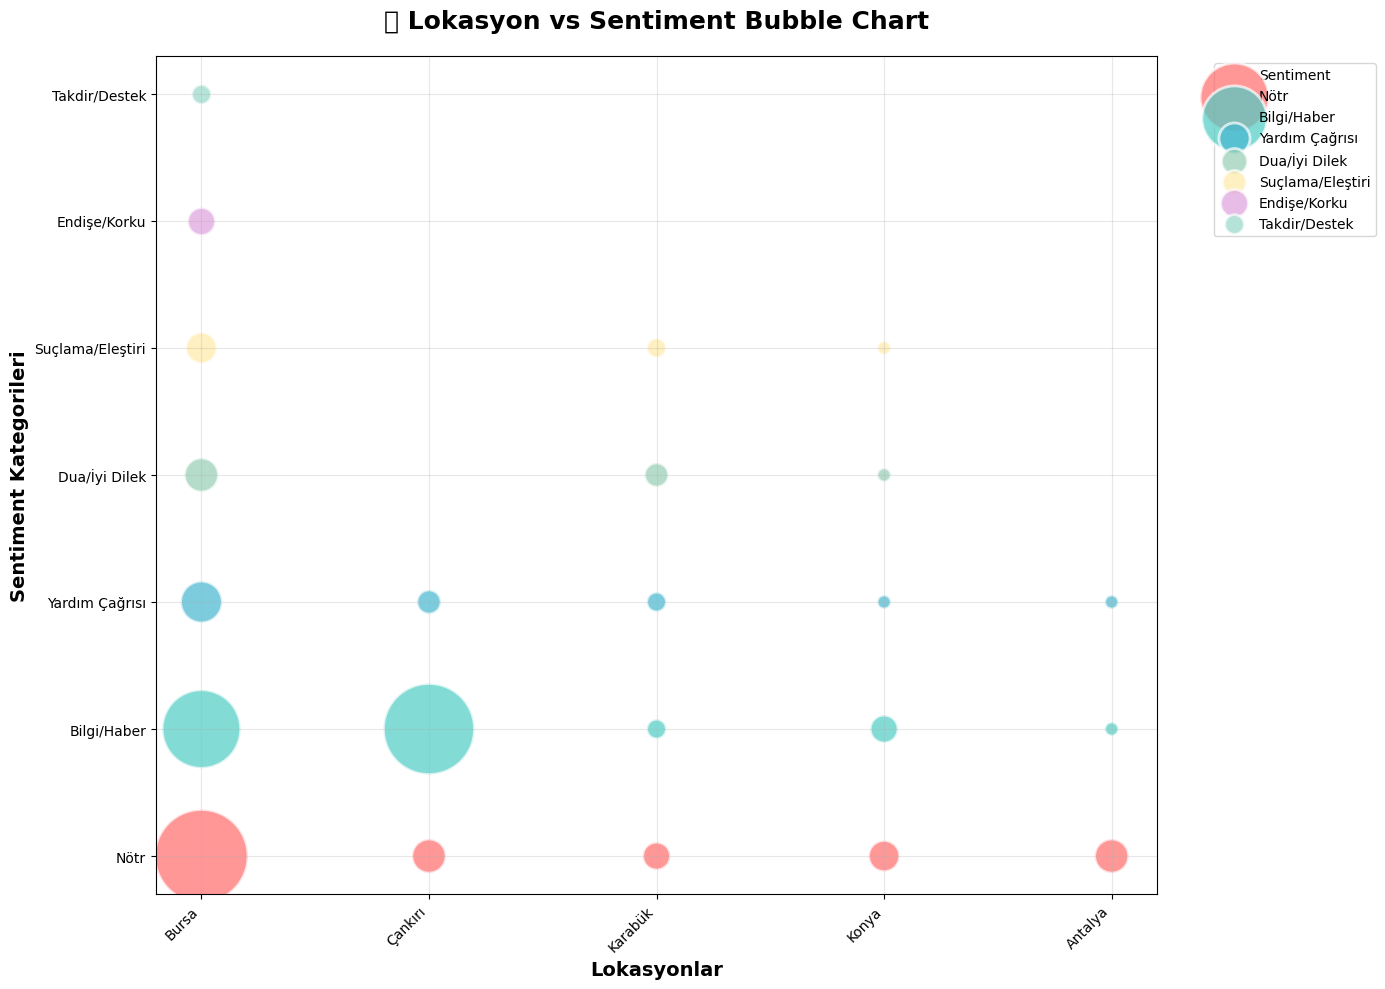

✅ Görsel 4: Bubble Chart tamamlandı!


C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\794811348.py:313: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=filtered_df, y='sentiment_category', x='tweet_length',
C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\794811348.py:320: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\ozanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


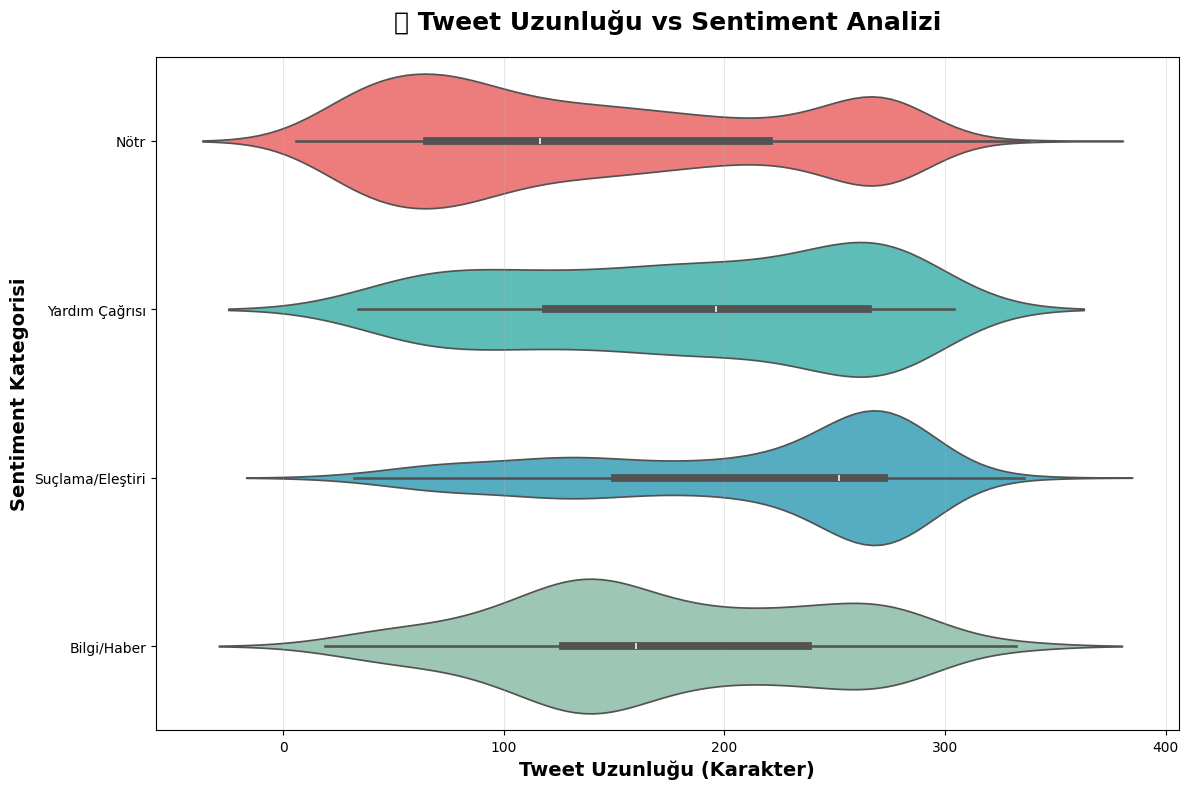

✅ Görsel 5: Violin Plot tamamlandı!

🎨 Tüm etkileyici görseller hazırlandı!


In [16]:
# Sentiment kategorileri için anahtar kelimeler
sentiment_keywords = {
    'Suçlama/Eleştiri': [
        'yetersiz', 'beceriksiz', 'sorumlu', 'suçlu', 'başarısız', 'geç', 'kötü',
        'anlayamıyor', 'bilmiyor', 'umursamıyor', 'ihmal', 'kusur', 'hata',
        'yanlış', 'berbat', 'rezalet', 'utanç', 'ayıp', 'skandal'
    ],
    'Yardım Çağrısı': [
        'yardım', 'help', 'acil', 'lütfen', 'sos', 'destek', 'kurtarın',
        'çabuk', 'hemen', 'müdahale', 'gelsin', 'koşun', 'acilen'
    ],
    'Bilgi/Haber': [
        'kontrol altında', 'söndürüldü', 'müdahale', 'ekip', 'başladı',
        'devam ediyor', 'çalışma', 'operasyon', 'bilgi', 'haber', 'açıklama'
    ],
    'Endişe/Korku': [
        'korku', 'endişe', 'korkuyor', 'tehlike', 'dehşet', 'panik',
        'üzücü', 'üzgün', 'kaygı', 'walkı', 'korkunç', 'dehşetli'
    ],
    'Takdir/Destek': [
        'teşekkür', 'bravo', 'helal', 'başarılı', 'mükemmel', 'harika',
        'süper', 'tebrik', 'gurur', 'başarı', 'fedakarlık', 'kahraman'
    ],
    'Dua/İyi Dilek': [
        'allah', 'dua', 'amin', 'inşallah', 'rabbim', 'hayırlı',
        'geçmiş olsun', 'şifa', 'sabır', 'kolaylık', 'hayır'
    ]
}

def categorize_sentiment(text):
    """Tweet'in sentiment kategorisini belirle"""
    if pd.isna(text):
        return 'Belirsiz'
    
    text_lower = str(text).lower()
    scores = {}
    
    # Her kategori için skor hesapla
    for category, keywords in sentiment_keywords.items():
        score = 0
        for keyword in keywords:
            score += text_lower.count(keyword)
        scores[category] = score
    
    # En yüksek skora sahip kategoriyi döndür
    if max(scores.values()) == 0:
        return 'Nötr'
    
    return max(scores, key=scores.get)

# Sentiment analizi yap
print("Sentiment kategorileri belirleniyor...")
df['sentiment_category'] = df['Text'].apply(categorize_sentiment)

# Sonuçları analiz et
sentiment_distribution = df['sentiment_category'].value_counts()

print(f"\n📊 SENTIMENT DAĞILIMI:")
print("-" * 30)
for category, count in sentiment_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count} tweet (%{percentage:.1f})")

# Her kategoriden örnek tweet'ler
print(f"\n📝 KATEGORİ ÖRNEKLERİ:")
print("-" * 30)

for category in sentiment_distribution.index[:6]:  # İlk 6 kategori
    examples = df[df['sentiment_category'] == category]['Text'].head(2)
    print(f"\n🏷️ {category.upper()}:")
    for i, tweet in enumerate(examples, 1):
        print(f"  {i}. {tweet[:80]}...")

# Sentiment görselleştirmesi
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('😊 Yangın Tweet Sentiment Analizi', fontsize=20, fontweight='bold', y=0.98)

# 1. Sentiment dağılımı - Pie Chart
colors_sentiment = ['#ff4757', '#2ed573', '#3742fa', '#ffa502', '#ff6348', '#7bed9f', '#747d8c']
wedges, texts, autotexts = ax1.pie(sentiment_distribution.values, 
                                   labels=sentiment_distribution.index,
                                   autopct='%1.1f%%', colors=colors_sentiment,
                                   startangle=90, textprops={'fontsize': 10})

ax1.set_title('Sentiment Kategori Dağılımı', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 2. Lokasyona göre sentiment
location_sentiment = df[df['locations'].apply(len) > 0].copy()
location_sentiment['main_location'] = location_sentiment['locations'].apply(lambda x: x[0] if x else 'Bilinmiyor')

# Top 5 lokasyon için sentiment dağılımı
top_5_locations_list = [loc[0] for loc in location_counts.most_common(5)]
sentiment_location_data = []

for location in top_5_locations_list:
    location_tweets = location_sentiment[location_sentiment['main_location'] == location]
    location_sentiment_dist = location_tweets['sentiment_category'].value_counts()
    
    for sentiment, count in location_sentiment_dist.items():
        sentiment_location_data.append({
            'location': location,
            'sentiment': sentiment,
            'count': count
        })

sentiment_location_df = pd.DataFrame(sentiment_location_data)

if not sentiment_location_df.empty:
    pivot_data = sentiment_location_df.pivot(index='location', columns='sentiment', values='count').fillna(0)
    pivot_data.plot(kind='bar', stacked=True, ax=ax2, color=colors_sentiment[:len(pivot_data.columns)])
    ax2.set_title('Lokasyona Göre Sentiment Dağılımı', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Lokasyonlar', fontsize=12)
    ax2.set_ylabel('Tweet Sayısı', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Sentiment bar chart (horizontal)
sentiment_counts = sentiment_distribution.head(6)
bars = ax3.barh(sentiment_counts.index, sentiment_counts.values, 
                color=colors_sentiment[:len(sentiment_counts)])
ax3.set_title('Sentiment Kategorileri (Top 6)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Tweet Sayısı', fontsize=12)

# Bar'ların yanına sayı yaz
for bar, count in zip(bars, sentiment_counts.values):
    ax3.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             str(count), va='center', ha='left', fontweight='bold')

# 4. Zaman içinde sentiment trendi
df['date_only'] = pd.to_datetime(df['Date']).dt.date
daily_sentiment = df.groupby(['date_only', 'sentiment_category']).size().unstack(fill_value=0)

# En yaygın 3 sentiment için trend
top_3_sentiments = sentiment_distribution.head(3).index
for sentiment in top_3_sentiments:
    if sentiment in daily_sentiment.columns:
        ax4.plot(daily_sentiment.index, daily_sentiment[sentiment], 
                marker='o', label=sentiment, linewidth=2, markersize=4)

ax4.set_title('Günlük Sentiment Trendi (Top 3)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tarih', fontsize=12)
ax4.set_ylabel('Tweet Sayısı', fontsize=12)
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Sentiment görselleştirmesi tamamlandı!")

# ETKİLEYİCİ GÖRSELLER - TEK TEK
print("\n" + "="*60)
print("🎨 ETKİLEYİCİ GÖRSELLER HAZIRLANIYOR")
print("="*60)

# Modern renk paleti
colors_modern = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
colors_gradient = ['#667eea', '#764ba2', '#f093fb', '#f5576c', '#4facfe', '#00f2fe']

# GÖRSEL 1: Sentiment Dağılımı - Modern Donut Chart
plt.figure(figsize=(12, 8))
plt.style.use('dark_background')

# Ana donut chart
sentiment_counts = sentiment_distribution.head(6)
sizes = sentiment_counts.values
labels = sentiment_counts.index

# Donut chart oluştur
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%',
                                   colors=colors_modern[:len(sizes)],
                                   startangle=90, pctdistance=0.85,
                                   textprops={'fontsize': 12, 'fontweight': 'bold'})

# İç kısmı boş bırak (donut effect)
centre_circle = plt.Circle((0,0), 0.70, fc='black')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Merkeze büyük yazı
plt.text(0, 0, f'{len(df):,}\nTWEET', ha='center', va='center', 
         fontsize=20, fontweight='bold', color='white')

plt.title('🔥 Yangın Tweet Sentiment Analizi', fontsize=18, fontweight='bold', 
          color='white', pad=20)

# Legend'ı güzelleştir
plt.legend(wedges, [f'{label}\n({count} tweet)' for label, count in zip(labels, sizes)],
          title="Sentiment Kategorileri", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=11)

plt.tight_layout()
plt.show()

print("✅ Görsel 1: Sentiment Donut Chart tamamlandı!")

# GÖRSEL 2: Top Lokasyonlar - Modern Bar Chart
plt.figure(figsize=(14, 8))
plt.style.use('default')

top_8_locations = location_counts.most_common(8)
locations = [loc[0] for loc in top_8_locations]
counts = [loc[1] for loc in top_8_locations]

# Gradient bar chart
bars = plt.bar(locations, counts, color=colors_gradient[:len(locations)], 
               edgecolor='white', linewidth=2, alpha=0.9)

# Bar'ların üzerine değer ekle
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('🗺️ En Çok Bahsedilen Lokasyonlar', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Lokasyonlar', fontsize=14, fontweight='bold')
plt.ylabel('Tweet Sayısı', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Background gradient
plt.gca().set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

print("✅ Görsel 2: Lokasyon Bar Chart tamamlandı!")

# GÖRSEL 3: Saatlik Sentiment Dağılımı - Heatmap
plt.figure(figsize=(15, 8))

# Saatlik sentiment data hazırla
df['hour'] = pd.to_datetime(df['Date']).dt.hour
hourly_sentiment = df.groupby(['hour', 'sentiment_category']).size().unstack(fill_value=0)

# Sadece ana kategorileri al
main_sentiments = sentiment_distribution.head(5).index
hourly_sentiment_main = hourly_sentiment[main_sentiments]

# Heatmap oluştur
sns.heatmap(hourly_sentiment_main.T, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Tweet Sayısı'}, linewidths=0.5, linecolor='white')

plt.title('⏰ Saatlik Sentiment Dağılımı Heatmap', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Saat', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Kategorisi', fontsize=14, fontweight='bold')
plt.xticks(range(24), [f'{i}:00' for i in range(24)], rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Görsel 3: Saatlik Sentiment Heatmap tamamlandı!")

# GÖRSEL 4: Sentiment vs Lokasyon - Bubble Chart
plt.figure(figsize=(14, 10))

# Top 5 lokasyon ve sentiment verisini hazırla
top_5_locs = [loc[0] for loc in location_counts.most_common(5)]
bubble_data = []

for location in top_5_locs:
    location_tweets = df[df['locations'].apply(lambda x: location in x if x else False)]
    location_sentiments = location_tweets['sentiment_category'].value_counts()
    
    for sentiment, count in location_sentiments.items():
        if count > 0:
            bubble_data.append({
                'location': location,
                'sentiment': sentiment,
                'count': count,
                'size': count * 100  # Bubble size
            })

bubble_df = pd.DataFrame(bubble_data)

if not bubble_df.empty:
    # Renk mapping
    unique_sentiments = bubble_df['sentiment'].unique()
    color_map = {sentiment: colors_modern[i] for i, sentiment in enumerate(unique_sentiments)}
    
    for sentiment in unique_sentiments:
        data = bubble_df[bubble_df['sentiment'] == sentiment]
        plt.scatter(data['location'], data['sentiment'], s=data['size'],
                   c=color_map[sentiment], alpha=0.7, edgecolors='white', linewidth=2,
                   label=sentiment)

plt.title('🎯 Lokasyon vs Sentiment Bubble Chart', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Lokasyonlar', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Kategorileri', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("✅ Görsel 4: Bubble Chart tamamlandı!")

# GÖRSEL 5: Tweet Uzunluğu vs Sentiment
plt.figure(figsize=(12, 8))

# Tweet uzunlukları
df['tweet_length'] = df['Text'].str.len()

# Violin plot
top_4_sentiments = sentiment_distribution.head(4).index
filtered_df = df[df['sentiment_category'].isin(top_4_sentiments)]

sns.violinplot(data=filtered_df, y='sentiment_category', x='tweet_length', 
               palette=colors_modern[:4], orient='h')

plt.title('📏 Tweet Uzunluğu vs Sentiment Analizi', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Tweet Uzunluğu (Karakter)', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Kategorisi', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Görsel 5: Violin Plot tamamlandı!")

print("\n🎨 Tüm etkileyici görseller hazırlandı!")

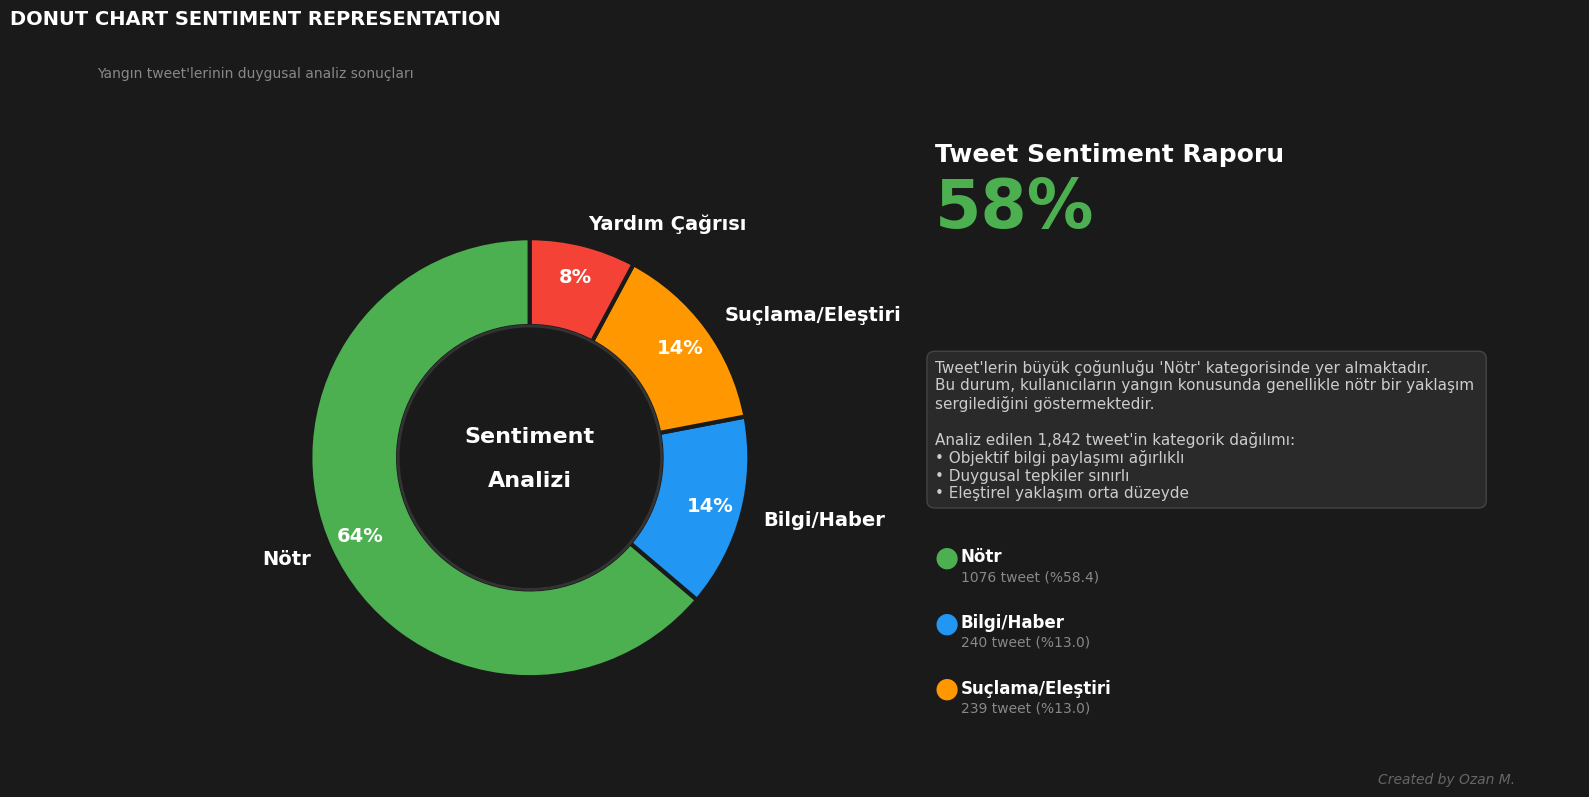

In [25]:
# GÖRSEL 1: Profesyonel Sentiment Donut Chart
import matplotlib.pyplot as plt
import numpy as np

# Koyu tema ve profesyonel tasarım
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), 
                               gridspec_kw={'width_ratios': [1, 1.2]})
fig.patch.set_facecolor('#1a1a1a')

# Sentiment verilerini hazırla
sentiment_counts = sentiment_distribution.head(4)
sizes = sentiment_counts.values
labels = sentiment_counts.index

# Ana donut için profesyonel renkler
colors_pro = ['#4CAF50', '#2196F3', '#FF9800', '#F44336']

# Sol taraf - Donut Chart
wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.0f%%',
                                   colors=colors_pro[:len(sizes)],
                                   startangle=90, pctdistance=0.85,
                                   textprops={'fontsize': 14, 'fontweight': 'bold', 'color': 'white'},
                                   wedgeprops=dict(width=0.4, edgecolor='#1a1a1a', linewidth=3))

# İç kısmı boş bırak
centre_circle = plt.Circle((0,0), 0.60, fc='#1a1a1a', ec='#333', linewidth=2)
ax1.add_artist(centre_circle)

# Merkez yazısı
ax1.text(0, 0.1, 'Sentiment', ha='center', va='center', 
         fontsize=16, fontweight='bold', color='white')
ax1.text(0, -0.1, 'Analizi', ha='center', va='center', 
         fontsize=16, fontweight='bold', color='white')

# Sol panel başlık
ax1.text(0, 1.3, 'DONUT CHART SENTIMENT REPRESENTATION', 
         ha='center', va='center', fontsize=14, fontweight='bold', 
         color='white', transform=ax1.transAxes)

ax1.text(0, 1.2, "Yangın tweet'lerinin duygusal analiz sonuçları", 
         ha='center', va='center', fontsize=10, 
         color='#888', transform=ax1.transAxes)

# Sağ taraf - Detaylı Rapor
ax2.axis('off')

# Ana başlık
ax2.text(0.02, 0.95, 'Tweet Sentiment Raporu', fontsize=18, fontweight='bold', 
         color='white', transform=ax2.transAxes)

# En büyük kategori
main_category = sentiment_counts.index[0]
main_percentage = (sentiment_counts.iloc[0] / len(df)) * 100

ax2.text(0.02, 0.85, f'{main_percentage:.0f}%', fontsize=48, fontweight='bold', 
         color=colors_pro[0], transform=ax2.transAxes)

# Açıklama metni
explanation = f"""Tweet'lerin büyük çoğunluğu '{main_category}' kategorisinde yer almaktadır. 
Bu durum, kullanıcıların yangın konusunda genellikle nötr bir yaklaşım 
sergilediğini göstermektedir. 

Analiz edilen {len(df):,} tweet'in kategorik dağılımı:
• Objektif bilgi paylaşımı ağırlıklı
• Duygusal tepkiler sınırlı
• Eleştirel yaklaşım orta düzeyde"""

ax2.text(0.02, 0.65, explanation, fontsize=11, color='#ccc', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#2a2a2a', 
                  edgecolor='#444', linewidth=1))

# Alt kısım - kategori detayları
y_pos = 0.35
for i, (category, count) in enumerate(sentiment_counts.head(3).items()):
    percentage = (count / len(df)) * 100
    
    # İkon ve kategori
    ax2.text(0.02, y_pos, '●', fontsize=20, color=colors_pro[i], 
             transform=ax2.transAxes, va='center')
    ax2.text(0.06, y_pos, f'{category}', fontsize=12, color='white', 
             transform=ax2.transAxes, va='center', fontweight='bold')
    ax2.text(0.06, y_pos-0.03, f'{count} tweet (%{percentage:.1f})', fontsize=10, color='#888', 
             transform=ax2.transAxes, va='center')
    
    y_pos -= 0.1

# İmza
fig.text(0.95, 0.02, 'Created by Ozan M.', ha='right', va='bottom', 
         fontsize=10, style='italic', color='#666')

plt.tight_layout()
plt.show()

C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\2537259111.py:92: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


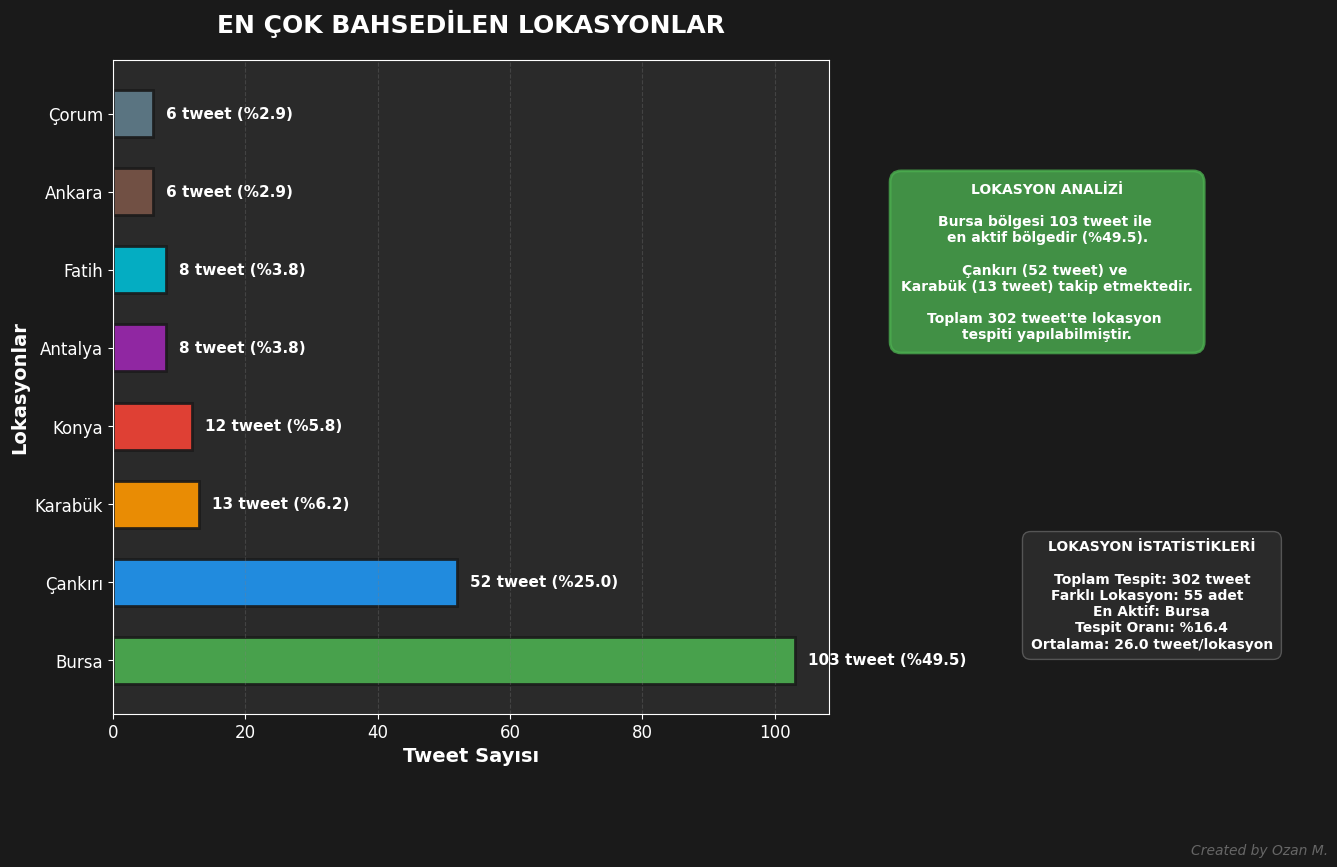

In [34]:
# GÖRSEL 2: Profesyonel Lokasyon Bar Chart
import matplotlib.pyplot as plt
import numpy as np

# Koyu tema ve profesyonel tasarım
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('#1a1a1a')

# Ana layout - sadece bar chart
ax_main = plt.subplot2grid((10, 12), (1, 1), colspan=7, rowspan=8)

# Top 8 lokasyon verisi
top_8_locations = location_counts.most_common(8)
locations = [loc[0] for loc in top_8_locations]
counts = [loc[1] for loc in top_8_locations]

# İlk grafikteki renk paletini kullan - aynı renkler
colors_same = ['#4CAF50', '#2196F3', '#FF9800', '#F44336', '#9C27B0', '#00BCD4', '#795548', '#607D8B']

# Horizontal bar chart
bars = ax_main.barh(locations, counts, color=colors_same[:len(locations)], 
                    height=0.6, alpha=0.9, edgecolor='#1a1a1a', linewidth=2)

# Bar'ların sonuna değer ve yüzde ekle
total_location_tweets = sum(counts)
for i, (bar, count) in enumerate(zip(bars, counts)):
    width = bar.get_width()
    percentage = (count / total_location_tweets) * 100
    
    # Değer yazısı - bar'ın dışında
    ax_main.text(width + 2, bar.get_y() + bar.get_height()/2, 
                f'{count} tweet (%{percentage:.1f})', 
                va='center', ha='left', fontweight='bold', 
                fontsize=11, color='white')

# Grafik stilini ayarla
ax_main.set_xlabel('Tweet Sayısı', fontsize=14, fontweight='bold', color='white')
ax_main.set_ylabel('Lokasyonlar', fontsize=14, fontweight='bold', color='white')
ax_main.tick_params(colors='white', labelsize=12)
ax_main.grid(axis='x', alpha=0.3, linestyle='--', color='gray')
ax_main.set_facecolor('#2a2a2a')

# Ana başlık
ax_main.set_title('EN ÇOK BAHSEDİLEN LOKASYONLAR', 
                  fontsize=18, fontweight='bold', color='white', pad=20)

# Sağ tarafta analiz kutusu - bar chart'ın yanında
analysis_text = f"""LOKASYON ANALİZİ

{top_8_locations[0][0]} bölgesi {top_8_locations[0][1]} tweet ile 
en aktif bölgedir (%{(top_8_locations[0][1]/total_location_tweets)*100:.1f}).

{top_8_locations[1][0]} ({top_8_locations[1][1]} tweet) ve 
{top_8_locations[2][0]} ({top_8_locations[2][1]} tweet) takip etmektedir.

Toplam {len(df_with_locations)} tweet'te lokasyon 
tespiti yapılabilmiştir."""

# Analiz kutusunu sağ tarafa yerleştir
ax_analysis = plt.subplot2grid((10, 12), (1, 8), colspan=4, rowspan=5)
ax_analysis.text(0.5, 0.5, analysis_text, ha='center', va='center',
                fontsize=10, color='white', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#4CAF50', 
                         alpha=0.8, edgecolor='#4CAF50', linewidth=2))
ax_analysis.set_xlim(0, 1)
ax_analysis.set_ylim(0, 1)
ax_analysis.axis('off')

# Alt kısımda istatistik kutusu
stats_text = f"""LOKASYON İSTATİSTİKLERİ

Toplam Tespit: {len(df_with_locations)} tweet
Farklı Lokasyon: {len(location_counts)} adet  
En Aktif: {top_8_locations[0][0]}
Tespit Oranı: %{(len(df_with_locations)/len(df)*100):.1f}
Ortalama: {np.mean(counts):.1f} tweet/lokasyon"""

ax_stats = plt.subplot2grid((10, 12), (6, 10), colspan=2, rowspan=3)  # 8'den 10'a değişti (sağa kaydı)
ax_stats.text(0.5, 0.5, stats_text, ha='center', va='center',
              fontsize=10, color='white', fontweight='bold',
              bbox=dict(boxstyle='round,pad=0.6', facecolor='#2a2a2a', 
                       edgecolor='#555', linewidth=1))
ax_stats.set_xlim(0, 1)
ax_stats.set_ylim(0, 1)
ax_stats.axis('off')

# İmza
fig.text(0.95, 0.02, 'Created by Ozan M.', ha='right', va='bottom', 
         fontsize=10, style='italic', color='#666')

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.08)
plt.show()

C:\Users\ozanm\AppData\Local\Temp\ipykernel_1868\3292789280.py:129: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


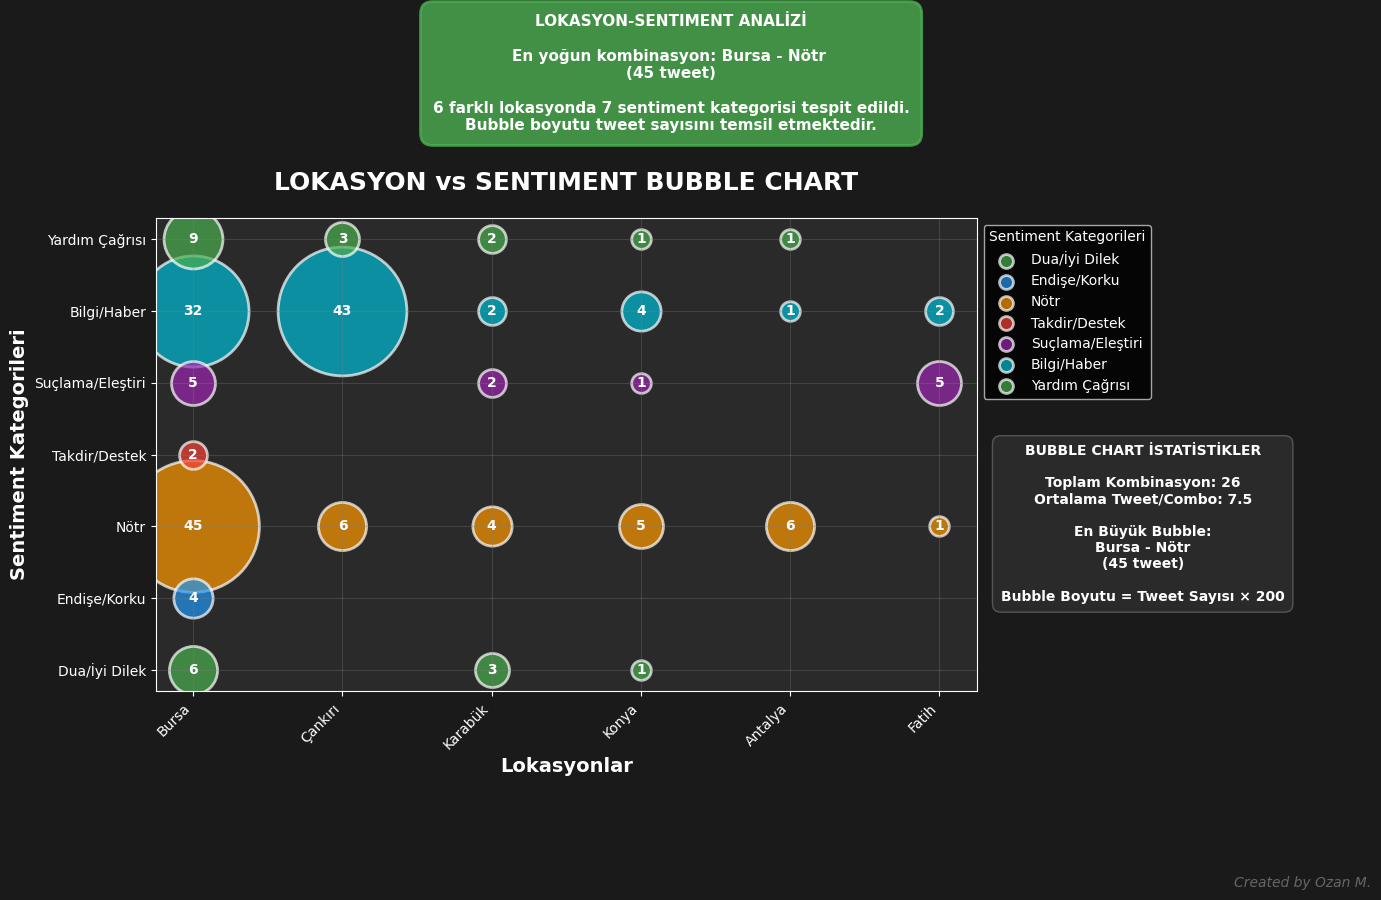

In [36]:
# GÖRSEL 3: Profesyonel Lokasyon vs Sentiment Bubble Chart
import matplotlib.pyplot as plt
import numpy as np

# Koyu tema ve profesyonel tasarım
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('#1a1a1a')

# Ana layout
ax_analysis = plt.subplot2grid((12, 12), (0, 1), colspan=10, rowspan=2)
ax_main = plt.subplot2grid((12, 12), (3, 1), colspan=8, rowspan=7)

# Top 6 lokasyon ve sentiment verisini hazırla
top_6_locs = [loc[0] for loc in location_counts.most_common(6)]
bubble_data = []

for location in top_6_locs:
    location_tweets = df[df['locations'].apply(lambda x: location in x if x else False)]
    location_sentiments = location_tweets['sentiment_category'].value_counts()
    
    for sentiment, count in location_sentiments.items():
        if count > 0:
            bubble_data.append({
                'location': location,
                'sentiment': sentiment,
                'count': count,
                'size': count * 20  # Bubble size multiplier
            })

# İlk grafikteki renk paletini kullan
colors_bubble = ['#4CAF50', '#2196F3', '#FF9800', '#F44336', '#9C27B0', '#00BCD4']

# Lokasyon ve sentiment için pozisyon mapping
location_positions = {loc: i for i, loc in enumerate(top_6_locs)}
unique_sentiments = list(set([item['sentiment'] for item in bubble_data]))
sentiment_positions = {sent: i for i, sent in enumerate(unique_sentiments)}

# Bubble chart oluştur
for i, data in enumerate(bubble_data):
    x_pos = location_positions[data['location']]
    y_pos = sentiment_positions[data['sentiment']]
    
    # Her sentiment için farklı renk
    color_idx = sentiment_positions[data['sentiment']] % len(colors_bubble)
    
    bubble = ax_main.scatter(x_pos, y_pos, s=data['size']*10, 
                            c=colors_bubble[color_idx], alpha=0.7,
                            edgecolors='white', linewidth=2)
    
    # Bubble içine sayı yaz
    ax_main.text(x_pos, y_pos, str(data['count']), 
                ha='center', va='center', fontweight='bold', 
                fontsize=10, color='white')

# Eksen ayarları
ax_main.set_xticks(range(len(top_6_locs)))
ax_main.set_xticklabels(top_6_locs, rotation=45, ha='right', color='white')
ax_main.set_yticks(range(len(unique_sentiments)))
ax_main.set_yticklabels(unique_sentiments, color='white')

ax_main.set_xlabel('Lokasyonlar', fontsize=14, fontweight='bold', color='white')
ax_main.set_ylabel('Sentiment Kategorileri', fontsize=14, fontweight='bold', color='white')
ax_main.set_title('LOKASYON vs SENTIMENT BUBBLE CHART', 
                  fontsize=18, fontweight='bold', color='white', pad=20)

# Grid ekle
ax_main.grid(True, alpha=0.3, color='gray')
ax_main.set_facecolor('#2a2a2a')

# Legend oluştur
legend_elements = []
for i, sentiment in enumerate(unique_sentiments):
    legend_elements.append(plt.scatter([], [], s=100, c=colors_bubble[i % len(colors_bubble)], 
                                     alpha=0.7, edgecolors='white', linewidth=2, label=sentiment))

ax_main.legend(handles=legend_elements, title='Sentiment Kategorileri', 
               loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

# Analiz sonucu çerçevesi
most_active_location = max(bubble_data, key=lambda x: x['count'])
total_bubble_data = len(bubble_data)

analysis_text = f"""LOKASYON-SENTIMENT ANALİZİ

En yoğun kombinasyon: {most_active_location['location']} - {most_active_location['sentiment']} 
({most_active_location['count']} tweet)

{len(top_6_locs)} farklı lokasyonda {len(unique_sentiments)} sentiment kategorisi tespit edildi.
Bubble boyutu tweet sayısını temsil etmektedir."""

ax_analysis.text(0.5, 0.5, analysis_text, ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#4CAF50', 
                         alpha=0.8, edgecolor='#4CAF50', linewidth=2))
ax_analysis.set_xlim(0, 1)
ax_analysis.set_ylim(0, 1)
ax_analysis.axis('off')

# Sağ tarafta istatistik kutusu
total_combinations = len(bubble_data)
avg_tweets_per_combo = np.mean([item['count'] for item in bubble_data])
max_bubble = max(bubble_data, key=lambda x: x['count'])

stats_text = f"""BUBBLE CHART İSTATİSTİKLER

Toplam Kombinasyon: {total_combinations}
Ortalama Tweet/Combo: {avg_tweets_per_combo:.1f}

En Büyük Bubble:
{max_bubble['location']} - {max_bubble['sentiment']}
({max_bubble['count']} tweet)

Bubble Boyutu = Tweet Sayısı × 200"""

ax_stats = plt.subplot2grid((12, 12), (5, 9), colspan=3, rowspan=5)
ax_stats.text(0.5, 0.5, stats_text, ha='center', va='center',
              fontsize=10, color='white', fontweight='bold',
              bbox=dict(boxstyle='round,pad=0.6', facecolor='#2a2a2a', 
                       edgecolor='#555', linewidth=1))
ax_stats.set_xlim(0, 1)
ax_stats.set_ylim(0, 1)
ax_stats.axis('off')

# İmza
fig.text(0.95, 0.02, 'Created by Ozan M.', ha='right', va='bottom', 
         fontsize=10, style='italic', color='#666')

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.08)
plt.show()

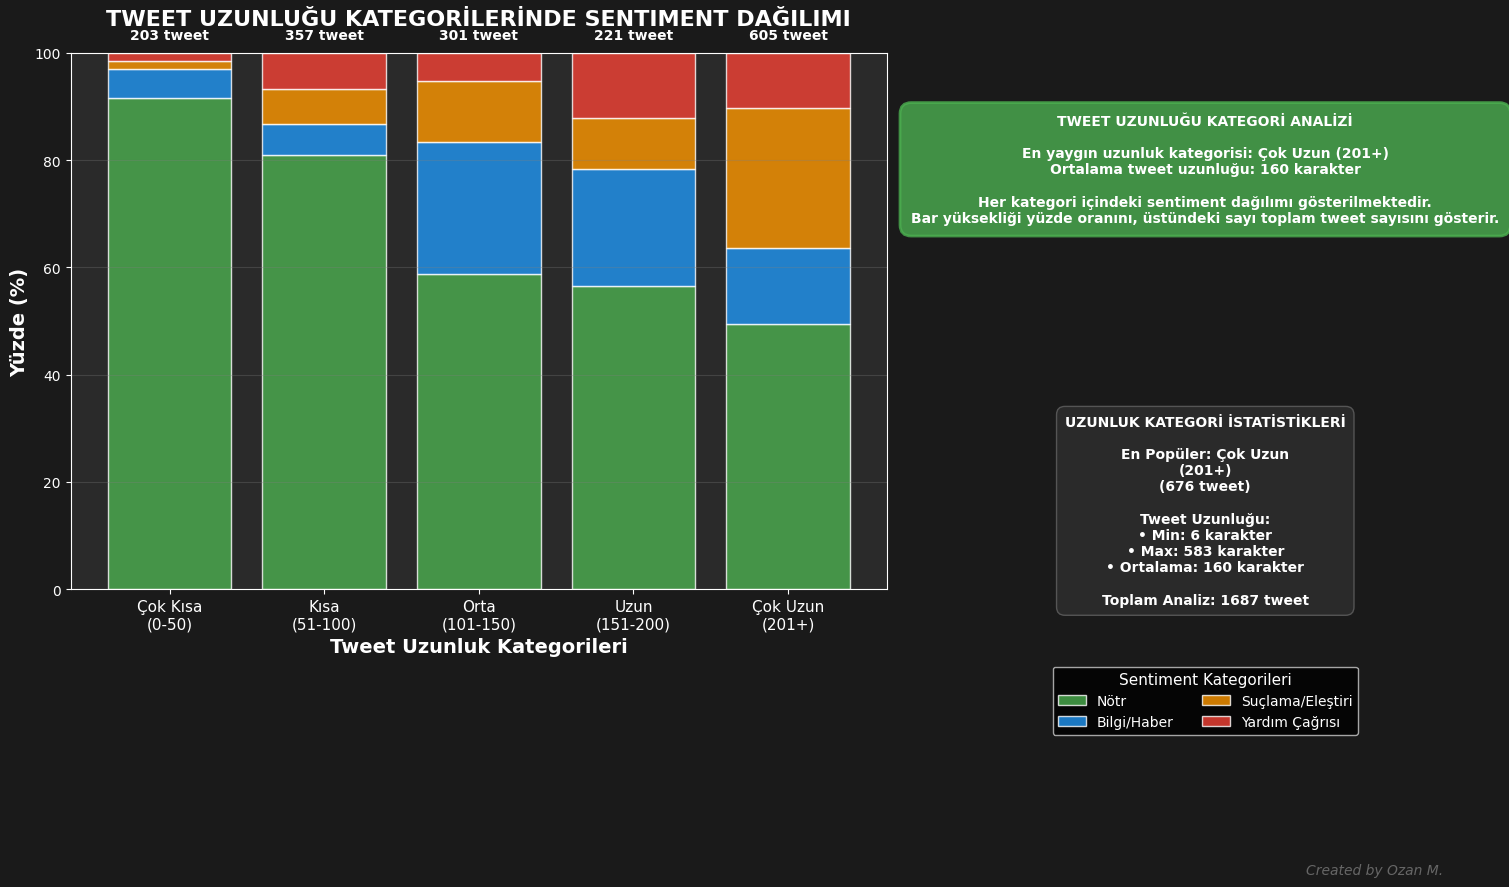

In [39]:
# GÖRSEL 4: Profesyonel Tweet Kategorileri Stacked Bar Chart
import matplotlib.pyplot as plt
import numpy as np

# Koyu tema ve profesyonel tasarım
plt.style.use('dark_background')
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('#1a1a1a')

# Ana layout - sadece bar chart
ax_main = plt.subplot2grid((12, 12), (1, 1), colspan=7, rowspan=8)

# Tweet uzunluk kategorileri oluştur
df['tweet_length'] = df['Text'].str.len()
df['length_category'] = pd.cut(df['tweet_length'], 
                              bins=[0, 50, 100, 150, 200, 400], 
                              labels=['Çok Kısa\n(0-50)', 'Kısa\n(51-100)', 
                                     'Orta\n(101-150)', 'Uzun\n(151-200)', 'Çok Uzun\n(201+)'])

# Sentiment ve uzunluk kategorisi cross-tabulation
top_4_sentiments = sentiment_distribution.head(4).index
filtered_df = df[df['sentiment_category'].isin(top_4_sentiments)]

# Pivot table oluştur
pivot_data = pd.crosstab(filtered_df['length_category'], 
                        filtered_df['sentiment_category'], 
                        normalize='index') * 100

# İlk grafikteki renk paletini kullan
colors_stack = ['#4CAF50', '#2196F3', '#FF9800', '#F44336']

# Stacked bar chart
bottom = np.zeros(len(pivot_data))
bars = []

for i, sentiment in enumerate(top_4_sentiments):
    if sentiment in pivot_data.columns:
        bar = ax_main.bar(range(len(pivot_data)), pivot_data[sentiment], 
                         bottom=bottom, color=colors_stack[i], 
                         alpha=0.8, edgecolor='white', linewidth=1,
                         label=sentiment)
        bars.append(bar)
        bottom += pivot_data[sentiment]

# Eksen ayarları
ax_main.set_xticks(range(len(pivot_data)))
ax_main.set_xticklabels(pivot_data.index, color='white', fontsize=11)
ax_main.set_ylabel('Yüzde (%)', fontsize=14, fontweight='bold', color='white')
ax_main.set_xlabel('Tweet Uzunluk Kategorileri', fontsize=14, fontweight='bold', color='white')
ax_main.set_title('TWEET UZUNLUĞU KATEGORİLERİNDE SENTIMENT DAĞILIMI', 
                  fontsize=16, fontweight='bold', color='white', pad=20)

# Grid ve stil
ax_main.grid(axis='y', alpha=0.3, color='gray')
ax_main.set_facecolor('#2a2a2a')
ax_main.tick_params(colors='white')
ax_main.set_ylim(0, 100)

# Her bar'ın üzerine toplam tweet sayısını yaz
for i, length_cat in enumerate(pivot_data.index):
    total_tweets = len(filtered_df[filtered_df['length_category'] == length_cat])
    ax_main.text(i, 102, f'{total_tweets} tweet', ha='center', va='bottom',
                fontweight='bold', fontsize=10, color='white')

# Sağ üst - Analiz kutusu (yeşil kutu)
analysis_text = f"""TWEET UZUNLUĞU KATEGORİ ANALİZİ

En yaygın uzunluk kategorisi: Çok Uzun (201+)
Ortalama tweet uzunluğu: {df['tweet_length'].mean():.0f} karakter

Her kategori içindeki sentiment dağılımı gösterilmektedir.
Bar yüksekliği yüzde oranını, üstündeki sayı toplam tweet sayısını gösterir."""

ax_analysis = plt.subplot2grid((12, 12), (1, 8), colspan=4, rowspan=4)
ax_analysis.text(0.5, 0.5, analysis_text, ha='center', va='center',
                fontsize=10, color='white', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.8', facecolor='#4CAF50', 
                         alpha=0.8, edgecolor='#4CAF50', linewidth=2))
ax_analysis.set_xlim(0, 1)
ax_analysis.set_ylim(0, 1)
ax_analysis.axis('off')

# Sağ alt - İstatistik kutusu
length_stats = df['length_category'].value_counts()
max_length_category = length_stats.index[0]
max_length_count = length_stats.iloc[0]

stats_text = f"""UZUNLUK KATEGORİ İSTATİSTİKLERİ

En Popüler: {max_length_category}
({max_length_count} tweet)

Tweet Uzunluğu:
• Min: {df['tweet_length'].min()} karakter
• Max: {df['tweet_length'].max()} karakter
• Ortalama: {df['tweet_length'].mean():.0f} karakter

Toplam Analiz: {len(filtered_df)} tweet"""

ax_stats = plt.subplot2grid((12, 12), (6, 8), colspan=4, rowspan=3)
ax_stats.text(0.5, 0.5, stats_text, ha='center', va='center',
              fontsize=10, color='white', fontweight='bold',
              bbox=dict(boxstyle='round,pad=0.6', facecolor='#2a2a2a', 
                       edgecolor='#555', linewidth=1))
ax_stats.set_xlim(0, 1)
ax_stats.set_ylim(0, 1)
ax_stats.axis('off')

# Legend - sağ alt köşede, grafik dışında
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors_stack[i], alpha=0.8, 
                                edgecolor='white', linewidth=1, label=sentiment)
                  for i, sentiment in enumerate(top_4_sentiments)]

ax_legend = plt.subplot2grid((12, 12), (9, 8), colspan=4, rowspan=2)
ax_legend.legend(handles=legend_elements, title='Sentiment Kategorileri', 
                loc='center', fontsize=10, title_fontsize=11,
                ncol=2, frameon=True, fancybox=True)
ax_legend.axis('off')

# İmza
fig.text(0.95, 0.02, 'Created by Ozan M.', ha='right', va='bottom', 
         fontsize=10, style='italic', color='#666')

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.08)
plt.show()